___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

## Overview

In this project, we will use The 2012 US Army Anthropometric Survey (ANSUR II) dataset [1] to predict the race of soldiers. The dataset consists of anthropometric and demographic data for both female and male soldiers. The ANSUR II dataset is a comprehensive collection of measurements and information gathered from a diverse population of soldiers. It includes a wide range of features such as height, weight, body circumference, limb lengths, facial measurements, and demographic attributes like age, gender, and ethnicity. In addition, we created a schema for easy mapping between the features and thier description. By leveraging this data, we aim to develop a model that can accurately classify the race of a soldier, using various algorithms capable of handling multiclass classification.


# Table of Contents

#### 1. Exploratory Data Analysis (EDA)

#### 2. Data Preprocessing

#### 3. Modelling

#### 4. SMOTE

#### 5. SHAP Analysis

#### 6. References

# EDA

In this section we will combine the female and malae datasets into one harmonized dataframe, examine the features, visualize the relationships, and drop irrelevant information.

In [2]:
#importing the libraries

import numpy as np
import pandas as pd
from numpy import mean
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint 

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay,RocCurveDisplay
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from scikitplot.metrics import plot_precision_recall
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
import shap
import warnings
import pickle

warnings.filterwarnings('ignore') 
sns.set_style('whitegrid')
pd.set_option('display.max_rows', None)

%matplotlib inline

### Combining the two datasets

In [3]:
df1 = pd.read_csv('ANSUR II MALE Public.csv', encoding = 'Latin-1')

In [4]:
df2 = pd.read_csv('ANSUR II FEMALE Public.csv', encoding = 'Latin-1')

In [5]:
# check if they have the same columns
set(df1.columns) == set(df2.columns)

False

In [6]:
# print uncommon items
set(df1.columns) ^ (set(df2.columns))

{'SubjectId', 'subjectid'}

In [7]:
df1.rename(columns={'subjectid': 'SubjectId'}, inplace=True)

In [8]:
set(df1.columns) == set(df2.columns)

True

In [9]:
df = pd.concat([df1, df2], axis = 0)

In [10]:
df.sample(2)

SubjectId  abdominalextensiondepthsitting  acromialheight  \
1692      15939                             306            1573   
3047      27296                             205            1410   

      acromionradialelength  anklecircumference  axillaheight  \
1692                    378                 243          1469   
3047                    327                 220          1313   

      balloffootcircumference  balloffootlength  biacromialbreadth  \
1692                      282               225                458   
3047                      257               210                407   

      bicepscircumferenceflexed  ...                  Branch  PrimaryMOS  \
1692                        387  ...  Combat Service Support         25U   
3047                        340  ...  Combat Service Support         35D   

      SubjectsBirthLocation  SubjectNumericRace  Ethnicity  DODRace  Age  \
1692               New York                   2        NaN        2   29   
3047             California                  61   Filipino        1   25   

      Heightin  Weightlbs  WritingPreference  
1692        75        225          Left hand  
3047        70        169         Right hand  

[2 rows x 108 columns]

## Schema

In [11]:
schema = pd.read_csv('ANSUR II Databases Overview.csv')
schema.head()

feature                                        description  \
0             SubjectId  A unique number for each participant measured ...   
1  SubjectBirthLocation  Subject Birth Location; a U.S. state or foreig...   
2    SubjectNumericRace  Subject Numeric Race; a single or multi-digit ...   
3             Ethnicity  self-reported ethnicity (verified through inte...   
4               DODRace  Department of Defense Race; a single digit ind...   

               type  
0  Demographic data  
1  Demographic data  
2  Demographic data  
3  Demographic data  
4  Demographic data

In [12]:
# removing the spaces from str
schema['feature'] = schema['feature'].str.strip()

In [13]:
def mapping(feature):
    '''
    Description:
    This function gets a column and map back its original description.
    
    INPUT:
    feature - (str) column name as a string
    
    OUTPUT:
    desc - (str) full description
    '''
    desc = list(schema[schema['feature'] == feature]['description'])
    return desc

In [14]:
# using pprint for better readability
pprint(mapping('Ethnicity'))

['self-reported ethnicity (verified through interview); e.g. “Mexican”, '
 '“Vietnamese”']


## Dropping columns with too many nulls

In [15]:
cols = set(df.columns)

In [16]:
#to handle missing values drop any columns that exceeds the threshold value

threshold = 0.5 # 50%
df = df.loc[:, df.isna().mean().lt(threshold)]

In [17]:
# show dropped columns
dropped = cols ^ set(df.columns)
list(dropped)

['Ethnicity']

## Dropping redundant/irrelevant features

In this section the features were mostly examined manually 

In [18]:
schema

feature  \
0                         SubjectId   
1              SubjectBirthLocation   
2                SubjectNumericRace   
3                         Ethnicity   
4                           DODRace   
5                            Gender   
6                               Age   
7                          Heightin   
8                         Weightlbs   
9                 WritingPreference   
10                             Date   
11                     Installation   
12                        Component   
13                           Branch   
14                       PrimaryMOS   
15                             NOTE   
16   abdominalextensiondepthsitting   
17                   acromialheight   
18            acromionradialelength   
19               anklecircumference   
20                     axillaheight   
21          balloffootcircumference   
22                 balloffootlength   
23                biacromialbreadth   
24        bicepscircumferenceflexed   
25                 bicristalbreadth   
26                 bideltoidbreadth   
27               bimalleolarbreadth   
28                 bitragionchinarc   
29        bitragionsubmandibulararc   
30               bizygomaticbreadth   
31             buttockcircumference   
32                     buttockdepth   
33                    buttockheight   
34                buttockkneelength   
35           buttockpopliteallength   
36                calfcircumference   
37                  cervicaleheight   
38                     chestbreadth   
39               chestcircumference   
40                       chestdepth   
41                      chestheight   
42                     crotchheight   
43            crotchlengthomphalion   
44   crotchlengthposterioromphalion   
45                       earbreadth   
46                        earlength   
47                    earprotrusion   
48                  elbowrestheight   
49                 eyeheightsitting   
50            footbreadthhorizontal   
51                       footlength   
52        forearmcenterofgriplength   
53       forearmcircumferenceflexed   
54            forearmforearmbreadth   
55                forearmhandlength   
56              functionalleglength   
57                      handbreadth   
58                handcircumference   
59                       handlength   
60                      headbreadth   
61                headcircumference   
62                       headlength   
63           heelanklecircumference   
64                      heelbreadth   
65                       hipbreadth   
66                hipbreadthsitting   
67               iliocristaleheight   
68            interpupillarybreadth   
69                       interscyei   
70                      interscyeii   
71             kneeheightmidpatella   
72                kneeheightsitting   
73   lateralfemoralepicondyleheight   
74           lateralmalleolusheight   
75          lowerthighcircumference   
76              mentonsellionlength   
77                neckcircumference   
78            neckcircumferencebase   
79    overheadfingertipreachsitting   
80                       palmlength   
81                  poplitealheight   
82             radialestylionlength   
83            shouldercircumference   
84              shoulderelbowlength   
85                   shoulderlength   
86                    sittingheight   
87           sleevelengthspinewrist   
88                    sleeveoutseam   
89                             span   
90                          stature   
91              suprasternaleheight   
92                   tenthribheight   
93               thighcircumference   
94                   thighclearance   
95                    thumbtipreach   
96                     tibialheight   
97                 tragiontopofhead   
98              trochanterionheight   
99    verticaltrunkcircumferenceusa   
100                 waistbacklength   
101                    waistbreadth   
102        

In [19]:
df['SubjectsBirthLocation'].value_counts()

California                  446
New York                    420
Texas                       397
Indiana                     266
Oklahoma                    221
Illinois                    216
Florida                     210
Minnesota                   200
Michigan                    196
Mississippi                 194
Georgia                     170
Alabama                     164
South Carolina              161
North Carolina              149
Ohio                        142
Louisiana                   137
Pennsylvania                132
Virginia                    118
Massachusetts               112
Wisconsin                   102
Germany                      92
New Jersey                   89
Puerto Rico                  88
Arizona                      84
Missouri                     84
Colorado                     81
Maryland                     80
Tennessee                    74
Kentucky                     69
Washington                   66
Kansas                       63
South Da

In [20]:
pprint(mapping('SubjectNumericRace'))

['Subject Numeric Race; a single or multi-digit code indicating a subject’s '
 'self-reported race or races (verified through interview). Where 1 = White, 2 '
 '= Black, 3 = Hispanic, 4 = Asian, 5 = Native American, 6 = Pacific Islander, '
 '8 = Other']


In [21]:
mapping('Weightlbs')

['Weight in Pounds; self-reported, comparable to measured “weightkg”']

In [22]:
mapping('Heightin')

['Height in Inches; self-reported, comparable to measured “stature”']

In [23]:
features_to_drop = [ 
    'SubjectId', # irrelavant
    'SubjectNumericRace', # redundant
    'Heightin', # redundant
    'Weightlbs',  # redundant
    'Date',  # irrelavant
    'Installation',  # irrelavant
    'PrimaryMOS', # irrelavant
    # 'WritingPreference', # there are some studies about its association with race so I'm not drpping it
    ]

In [24]:
# dropping the features
df = df.drop(features_to_drop, axis=1)

### Feature Engineering

In [25]:
# drop values with count less than 50 to reduce columns after transformation

counts = df['SubjectsBirthLocation'].value_counts()

values_to_drop = counts[counts <= 50]

mask = df['SubjectsBirthLocation'].isin(values_to_drop.index)

# keep the rows where the mask is False
df = df[~mask]

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5188 entries, 1 to 1985
Data columns (total 100 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   abdominalextensiondepthsitting  5188 non-null   int64 
 1   acromialheight                  5188 non-null   int64 
 2   acromionradialelength           5188 non-null   int64 
 3   anklecircumference              5188 non-null   int64 
 4   axillaheight                    5188 non-null   int64 
 5   balloffootcircumference         5188 non-null   int64 
 6   balloffootlength                5188 non-null   int64 
 7   biacromialbreadth               5188 non-null   int64 
 8   bicepscircumferenceflexed       5188 non-null   int64 
 9   bicristalbreadth                5188 non-null   int64 
 10  bideltoidbreadth                5188 non-null   int64 
 11  bimalleolarbreadth              5188 non-null   int64 
 12  bitragionchinarc                5188 non-null  

## Explore Data

In [28]:
# checking for null values
df.isnull().sum().any()

False

In [29]:
# checking for duplicates
df.duplicated().sum()

0

In [30]:
df.describe().T

count         mean         std     min  \
abdominalextensiondepthsitting  5188.0   247.228604   37.823989   155.0   
acromialheight                  5188.0  1408.196222   77.821039  1146.0   
acromionradialelength           5188.0   327.957594   20.375474   249.0   
anklecircumference              5188.0   225.240170   15.989952   156.0   
axillaheight                    5188.0  1301.329414   70.774073  1062.0   
balloffootcircumference         5188.0   244.462028   16.803400   186.0   
balloffootlength                5188.0   195.147648   13.347810   151.0   
biacromialbreadth               5188.0   400.039129   29.956350   296.0   
bicepscircumferenceflexed       5188.0   341.746916   41.511881   230.0   
bicristalbreadth                5188.0   275.073824   19.352756   197.0   
bideltoidbreadth                5188.0   491.870856   42.001293   357.0   
bimalleolarbreadth              5188.0    72.329607    5.298427    55.0   
bitragionchinarc                5188.0   324.876446   17.055155   267.0   
bitragionsubmandibulararc       5188.0   306.729761   20.785107   246.0   
bizygomaticbreadth              5188.0   139.573053    7.282391   116.0   
buttockcircumference            5188.0  1022.066885   77.050358   737.0   
buttockdepth                    5188.0   242.246723   26.708034   168.0   
buttockheight                   5188.0   871.632228   53.748904   656.0   
buttockkneelength               5188.0   610.186006   33.074696   479.0   
buttockpopliteallength          5188.0   498.037394   28.443074   380.0   
calfcircumference               5188.0   386.560139   30.726836   266.0   
cervicaleheight                 5188.0  1479.695644   82.927825  1208.0   
chestbreadth                    5188.0   283.530455   20.625304   213.0   
chestcircumference              5188.0  1024.358520  100.971370   726.0   
chestdepth                      5188.0   252.170971   26.934029   171.0   
chestheight                     5188.0  1253.827679   78.214971   995.0   
crotchheight                    5188.0   826.388204   53.562804   610.0   
crotchlengthomphalion           5188.0   622.831534   45.510642   473.0   
crotchlengthposterioromphalion  5188.0   351.792598   29.802721   247.0   
earbreadth                      5188.0    35.191018    3.224452    25.0   
earlength                       5188.0    62.602352    4.869349    46.0   
earprotrusion                   5188.0    22.245374    3.161626    13.0   
elbowrestheight                 5188.0   240.865844   28.627503   138.0   
eyeheightsitting                5188.0   786.756361   41.802924   654.0   
footbreadthhorizontal           5188.0    98.942174    6.661941    77.0   
footlength                      5188.0   263.495181   17.186650   210.0   
forearmcenterofgriplength       5188.0   339.306091   22.849698   258.0   
forearmcircumferenceflexed      5188.0   295.847533   29.976472   214.0   
forearmforearmbreadth           5188.0   553.466654   62.343976   384.0   
forearmhandlength               5188.0   467.744988   29.510686   342.0   
functionalleglength             5188.0  1103.561681   67.429506   835.0   
handbreadth                     5188.0    85.138011    6.340496    67.0   
handcircumference               5188.0   204.289322   15.521118   152.0   
handlength                      5188.0   189.497494   11.402811   155.0   
headbreadth                     5188.0   152.063994    6.155506   131.0   
headcircumference               5188.0   570.409406   18.190711   500.0   
headlength                      5188.0   196.692174    8.280500   168.0   
heelanklecircumference          5188.0   333.090594   22.169116   258.0   
heelbreadth                     5188.0    70.744796    5.901219    48.0   
hipbreadth                      5188.0   348.972436   25.424831   264.0   
hipbreadthsitting               5188.0   386.320933   32.653407   280.0   
iliocristaleheight              5188.0  1041.696608   58.764368   816.0   
interpupillarybreadth           5188.0   631.708558   36.3

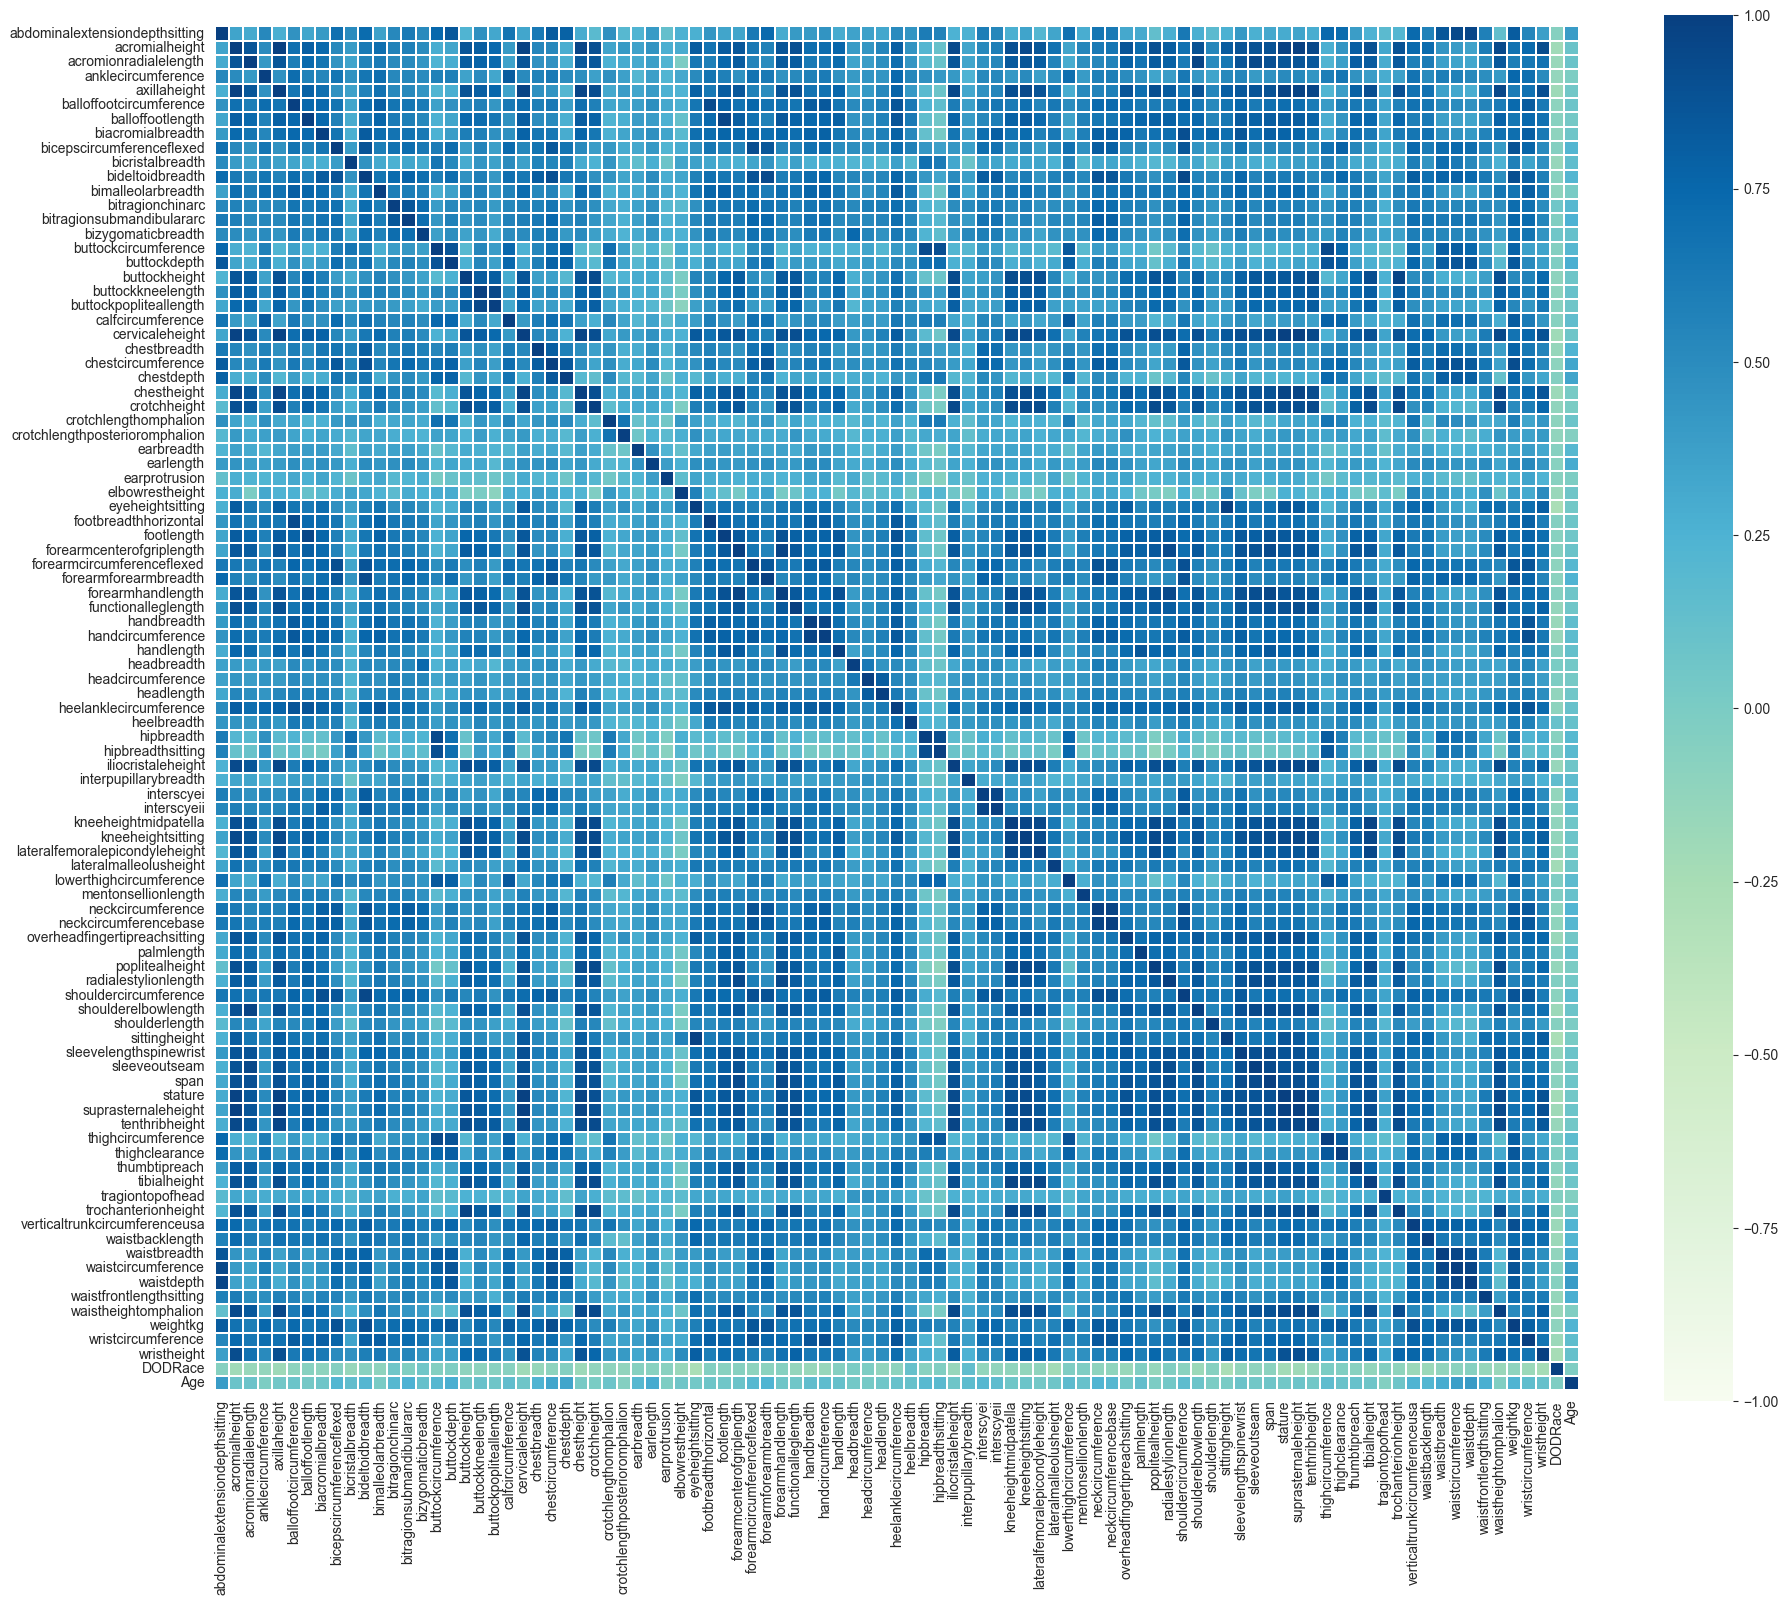

In [31]:
plt.figure(figsize=(22, 18))
sns.heatmap(df.corr(numeric_only=True), 
            vmin=-1,
            vmax= 1,
            cmap= 'GnBu', 
            linewidths=.12, 
            linecolor='white',
            fmt='.2g',
            square=True);

It's hard to visualuze the correlation since we have too many features

In [32]:
# show correlated features with 0.9 correlation scores
correlations = df.corr(numeric_only=True).unstack().sort_values()
highest_corr = correlations[correlations > 0.9]
highest_corr

sleevelengthspinewrist          sleeveoutseam                     0.900736
sleeveoutseam                   sleevelengthspinewrist            0.900736
buttockheight                   kneeheightsitting                 0.901279
kneeheightsitting               buttockheight                     0.901279
suprasternaleheight             functionalleglength               0.901527
functionalleglength             suprasternaleheight               0.901527
lateralfemoralepicondyleheight  trochanterionheight               0.901944
trochanterionheight             lateralfemoralepicondyleheight    0.901944
weightkg                        verticaltrunkcircumferenceusa     0.902194
verticaltrunkcircumferenceusa   weightkg                          0.902194
tenthribheight                  lateralfemoralepicondyleheight    0.902233
lateralfemoralepicondyleheight  tenthribheight                    0.902233
kneeheightmidpatella            axillaheight                      0.902339
axillaheight             

In [33]:
pprint(mapping('DODRace'))

['Department of Defense Race; a single digit indicating a subject’s '
 'self-reported preferred single race where selecting multiple races is not an '
 'option. This variable is intended to be comparable to the Defense Manpower '
 'Data Center demographic data. Where 1 = White, 2 = Black, 3 = Hispanic, 4 = '
 'Asian, 5 = Native American, 6 = Pacific Islander, 8 = Other']


In [34]:
df['DODRace'] = df['DODRace'].map({
1:'White', 2:'Black', 3:'Hispanic',
4:'Asian', 5:'Native American', 
6:'Pacific Islander', 8:'Other'})

In [35]:
value_counts = df['DODRace'].value_counts()

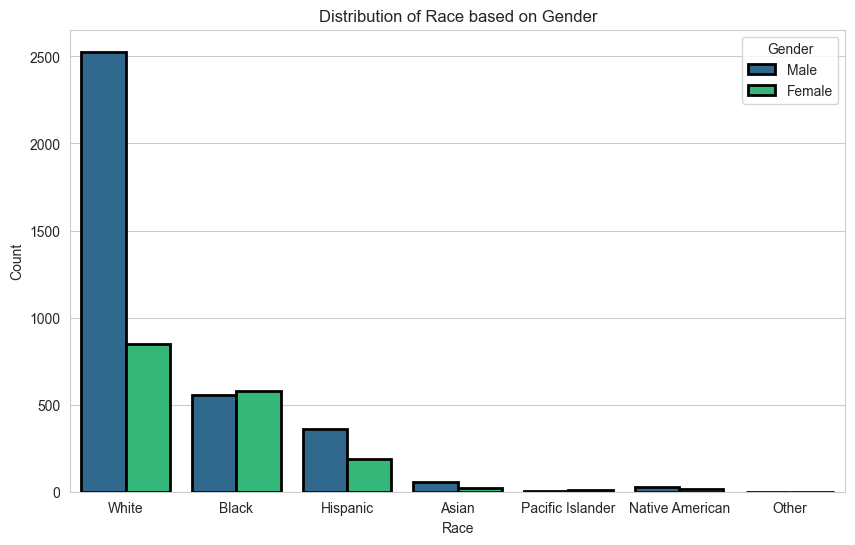

In [36]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='DODRace', hue='Gender', saturation=1, edgecolor='k',
              linewidth=2, palette='viridis')
plt.title(f'Distribution of Race based on Gender')
plt.xlabel('Race')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()

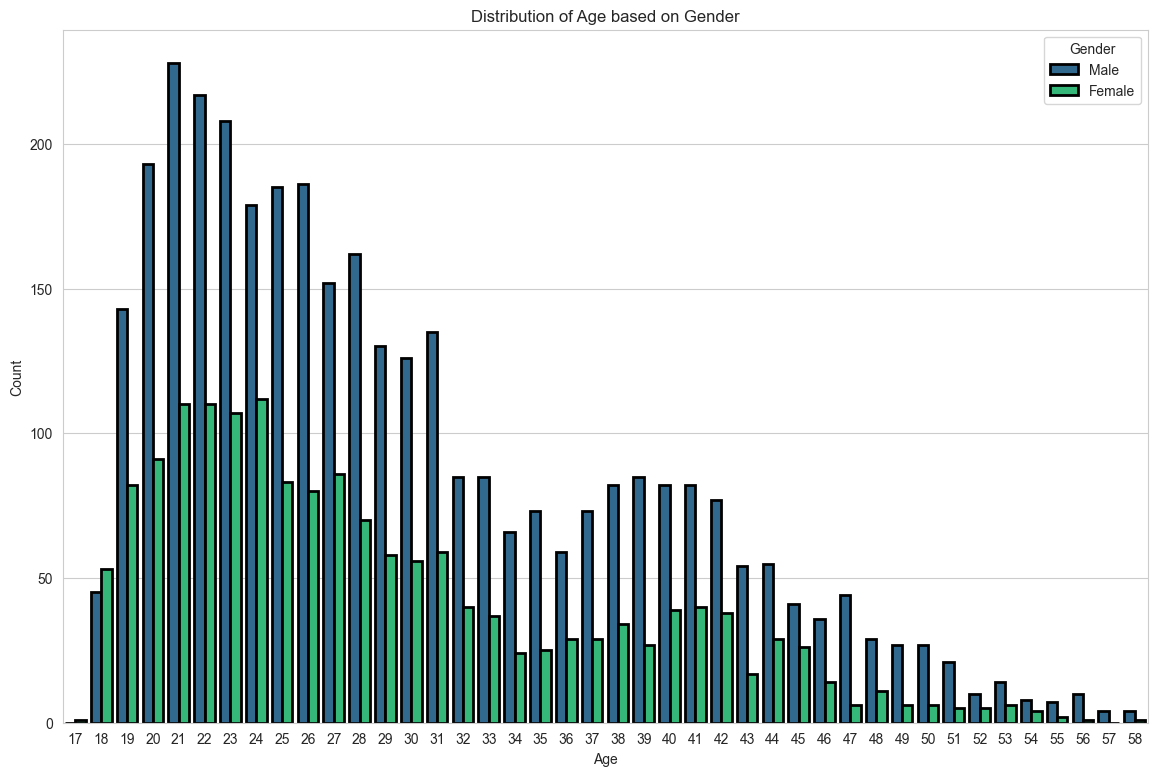

In [37]:
plt.figure(figsize=(14, 9))
sns.countplot(data=df, x='Age', hue='Gender', saturation=1, edgecolor='k',
              linewidth=2, palette='viridis')
plt.title(f'Distribution of Age based on Gender')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()

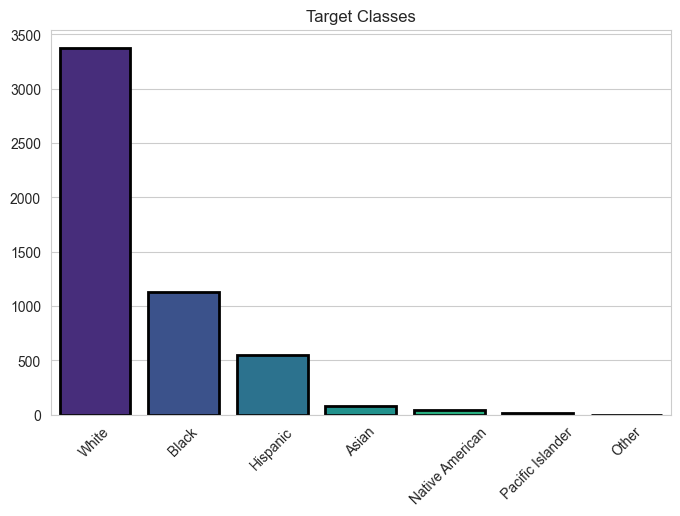

In [38]:
# visualizing our target distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=value_counts.index, y=value_counts.values,
            saturation=1, edgecolor='k',
            linewidth=2, palette='viridis')
plt.xticks(rotation=45)
plt.title(f'Target Classes')
plt.show()

We're going to predict classes with count higher than 500

In [39]:
value_counts = df['DODRace'].value_counts()

# classes with count of 500 or more
race_classes = list(value_counts[value_counts >= 500].index)
race_classes

['White', 'Black', 'Hispanic']

In [40]:
# keep rows that has one of the 3 classes
df = df[df['DODRace'].isin(race_classes)]
df.shape

(5053, 100)

## Outliers handling

In [41]:
df.reset_index(drop=True, inplace=True)

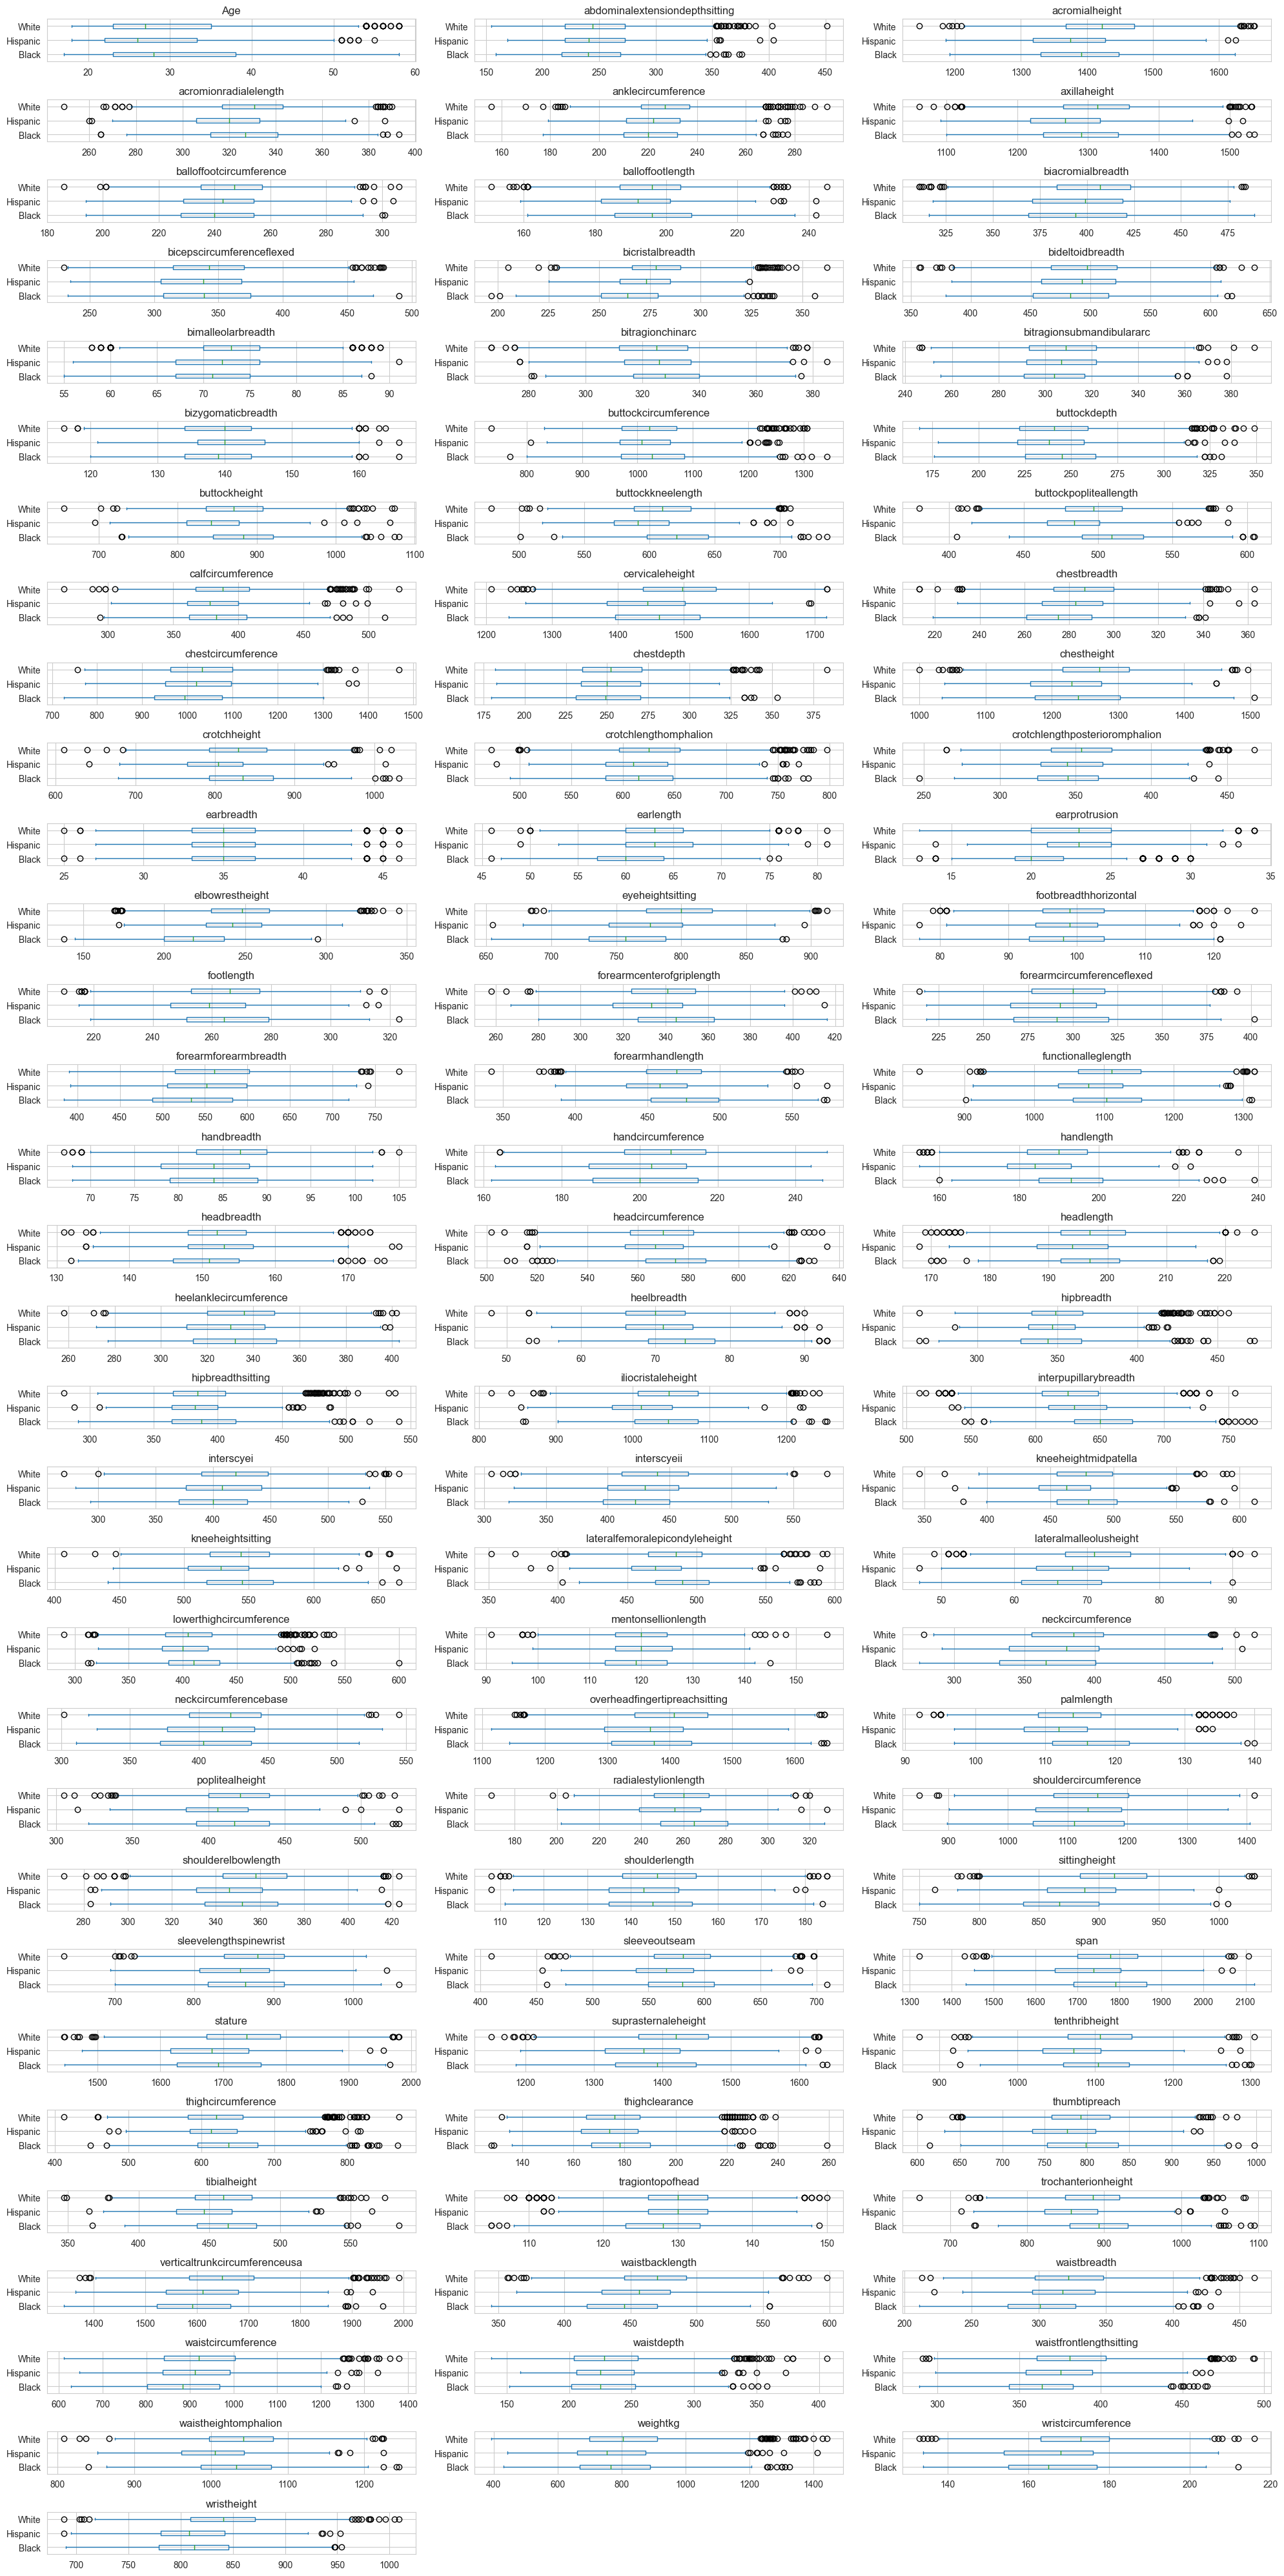

In [42]:
df.plot(by='DODRace', kind='box', subplots=True, layout=(32, 3),
        figsize=(20, 40), vert=False, sharex=False, sharey=False)
plt.tight_layout()

Since the values represent real measurments, the effect of outliers should not be huge, so we will not drop them 
* using MinMax scaler to handle outliers

### Data harmonization
must check for consistent units of Measurement

In [43]:
mapping('NOTE')

['measurements are recorded in millimeters with the exception of the variable “weightkg”.']

In [44]:
subset = df.describe().T
subset = subset[['std', 'mean', 'max', 'min']]
subset

std         mean     max     min
abdominalextensiondepthsitting   37.824402   247.623194   451.0   155.0
acromialheight                   77.636974  1409.068474  1654.0  1146.0
acromionradialelength            20.283925   328.201464   393.0   249.0
anklecircumference               15.961740   225.347714   293.0   156.0
axillaheight                     70.591814  1302.116367  1535.0  1062.0
balloffootcircumference          16.814719   244.537502   306.0   186.0
balloffootlength                 13.315197   195.254898   245.0   151.0
biacromialbreadth                29.912093   400.184643   489.0   311.0
bicepscircumferenceflexed        41.403987   342.084702   490.0   230.0
bicristalbreadth                 19.358772   275.085692   362.0   197.0
bideltoidbreadth                 41.944485   492.153572   637.0   357.0
bimalleolarbreadth                5.293801    72.363349    91.0    55.0
bitragionchinarc                 17.020788   324.924006   385.0   267.0
bitragionsubmandibulararc        20.788486   306.755987   390.0   246.0
bizygomaticbreadth                7.263953   139.490995   166.0   116.0
buttockcircumference             76.842712  1022.945577  1341.0   737.0
buttockdepth                     26.661972   242.511775   349.0   168.0
buttockheight                    53.517765   872.302197  1080.0   656.0
buttockkneelength                32.884621   610.735801   736.0   479.0
buttockpopliteallength           28.263069   498.505047   605.0   380.0
calfcircumference                30.709374   386.666139   523.0   266.0
cervicaleheight                  82.789282  1480.520087  1718.0  1208.0
chestbreadth                     20.615536   283.662577   363.0   213.0
chestcircumference              100.723156  1025.315456  1469.0   726.0
chestdepth                       26.809081   252.438156   383.0   180.0
chestheight                      78.060710  1254.591530  1506.0  1000.0
crotchheight                     53.353292   827.119731  1031.0   610.0
crotchlengthomphalion            45.430513   623.157926   797.0   473.0
crotchlengthposterioromphalion   29.821898   352.000792   468.0   247.0
earbreadth                        3.215658    35.211953    46.0    25.0
earlength                         4.863725    62.607164    81.0    46.0
earprotrusion                     3.150849    22.233920    34.0    13.0
elbowrestheight                  28.706516   240.716802   345.0   138.0
eyeheightsitting                 41.854420   786.882644   912.0   654.0
footbreadthhorizontal             6.668756    98.955670   126.0    77.0
footlength                       17.165563   263.649119   323.0   210.0
forearmcenterofgriplength        22.857529   339.548189   416.0   258.0
forearmcircumferenceflexed       29.922807   296.117356   402.0   214.0
forearmforearmbreadth            62.250664   553.881061   778.0   384.0
forearmhandlength                29.483425   468.056204   574.0   342.0
functionalleglength              67.207679  1104.456363  1316.0   835.0
handbreadth                       6.331111    85.200871   105.0    67.0
handcircumference                15.498777   204.456165   248.0   162.0
handlength                       11.379845   189.607956   239.0   155.0
headbreadth                       6.154992   152.016822   177.0   131.0
headcircumference                18.201758   570.547793   635.0   502.0
headlength                        8.246451   196.794182   225.0   168.0
heelanklecircumference           22.115041   333.347121   403.0   258.0
heelbreadth                       5.906793    70.779933    93.0    48.0
hipbreadth                       25.387282   349.210964   473.0   264.0
hipbreadthsitting                32.596390   386.636849   541.0   280.0
iliocristaleheight               58.527583  1042.422125  1253.0   816.0
interpupillarybreadth            36.427210   631.774985   770.0   510.0
interscyei                       42.786114   413.402731   562.0   270.0
interscyeii                      38.342363   433.588957   577.0   306.0
kneehei

all the data are in correct units

# DATA Preprocessing


### Data Splitting

In [45]:
# splitting X and y
X = df.drop(columns = ['DODRace'])
y = df['DODRace']

In [46]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=2023)

In [47]:
X_train.shape

(4042, 99)

In [48]:
X_test.shape

(1011, 99)

### Column Transformer

In [49]:
cat_columns = list(df.select_dtypes(include=['object']).columns)
cat_columns.remove('DODRace')

In [50]:
cat_columns

['Gender', 'Component', 'Branch', 'SubjectsBirthLocation', 'WritingPreference']

In [51]:
column_trans = make_column_transformer((
               OneHotEncoder( handle_unknown='ignore',
                              sparse_output=False), 
                              cat_columns),
                              remainder = 'passthrough', 
                              verbose_feature_names_out=False).set_output(transform="pandas")

In [52]:
# our scaller 
sc = MinMaxScaler()

# Modelling
We are going to try 4 algorithms
- Logistic Regression
- SVM
- Random Forest
- XGBoost

### Evaluation metric

In [53]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    '''
    Description:
    This function gets a model, train and test sets and return 
    the confusion matrix and classification report
    
    INPUT:
    model - fitted model
    X_train - input features for the training set
    y_train - target values for training set
    X_test - input features for the testing set
    y_test - target values for testing set
    
    RETURN:
    Nothing

    '''
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)

    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))
    print()
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

### Scorrer for Hispanic Class

Hispanic class performed way worse during the early experiments, so our focus will be to increase the recall scores for this class 

In [54]:
f1_hespanic = make_scorer(f1_score, average=None, labels=['Hispanic'])

precision_hespanic = make_scorer(precision_score, average=None, labels=['Hispanic'])

recall_hespanic = make_scorer(recall_score, average=None, labels=['Hispanic'])


scoring = {'f1_hespanic': f1_hespanic,
           'precision_hespanic': precision_hespanic, 
           'recall_hespanic': recall_hespanic}

## 1. Logistic model

### Vanilla Logistic Model

In [55]:
# Linear regression model
lr = LogisticRegression(max_iter=1000, random_state=2023)
# setting max iteration to 1000 for multiclass to make sure solvers have enough iterations to converge
lr_pipe = make_pipeline(column_trans, sc, lr)

lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'Component',
                                                   'Branch',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=2023))])

In [56]:
eval_metric(lr_pipe, X_train, y_train, X_test, y_test)

Train_Set
[[ 833   14   58]
 [  18  227  193]
 [  20   46 2633]]
              precision    recall  f1-score   support

       Black       0.96      0.92      0.94       905
    Hispanic       0.79      0.52      0.63       438
       White       0.91      0.98      0.94      2699

    accuracy                           0.91      4042
   macro avg       0.89      0.80      0.84      4042
weighted avg       0.91      0.91      0.91      4042


Test_Set
[[196   3  27]
 [  7  59  44]
 [  4  17 654]]
              precision    recall  f1-score   support

       Black       0.95      0.87      0.91       226
    Hispanic       0.75      0.54      0.62       110
       White       0.90      0.97      0.93       675

    accuracy                           0.90      1011
   macro avg       0.87      0.79      0.82      1011
weighted avg       0.90      0.90      0.89      1011



In [57]:
scores = cross_validate(lr_pipe,
                        X_train,
                        y_train,
                        scoring=scoring,
                        cv = 10,
                        n_jobs=-1,
                        return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_f1_hespanic            0.602905
train_f1_hespanic           0.626708
test_precision_hespanic     0.780929
train_precision_hespanic    0.793298
test_recall_hespanic        0.495560
train_recall_hespanic       0.518010
dtype: float64

### Logistic Model GridsearchCV

In [58]:
lr_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    ['Gender', 'Component', 'Branch',
                                     'SubjectsBirthLocation',
                                     'WritingPreference'])],
                     verbose_feature_names_out=False)),
  ('minmaxscaler', MinMaxScaler()),
  ('logisticregression',
   LogisticRegression(max_iter=1000, random_state=2023))],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse_output=False),
                                  ['Gender', 'Component',

In [59]:
lr_param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1],
              'logisticregression__class_weight': ['balanced', {'White':1,'Hispanic':3.5,'Black':2}, 
              {'White':1,'Hispanic':4,'Black':2.5}, {'White':1,'Hispanic':4.5,'Black':2}],
              'logisticregression__penalty': ['l1', 'l2'],
              # from docs : For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
              'logisticregression__solver': ['liblinear','sag','saga','newton-cg'],
              }

Warning

The choice of the algorithm depends on the penalty chosen. Supported penalties by solver:

- ‘lbfgs’ - [‘l2’, None]

- ‘liblinear’ - [‘l1’, ‘l2’]

- ‘newton-cg’ - [‘l2’, None]

- ‘newton-cholesky’ - [‘l2’, None]

- ‘sag’ - [‘l2’, None]

- ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, None]



The grid search will ignore incorrect combinations 

In [60]:
lr_model_grid = GridSearchCV(lr_pipe,
                              lr_param_grid ,
                              scoring=recall_hespanic,
                              cv=10,
                              n_jobs=-1,
                              return_train_score=True)
lr_model_grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Gender',
                                                                          'Component',
                                                                          'Branch',
                                                                          'SubjectsBirthLocation',
                                                                          'WritingPreference'])],
                                                          verbose_feature_names_out=False)),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('logist...
                         'logisticregression__class_weight': ['balanced',
                                                              {'Black': 2,
                                                               'Hispanic': 3.5,
                                                               'White': 1},
                                                              {'Black': 2.5,
                                                               'Hispanic': 4,
                                                               'White': 1},
                                                              {'Black': 2,
                                                               'Hispanic': 4.5,
                                                               'White': 1}],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear', 'sag',
                                                        'saga', 'newton-cg']},
             return_train_score=True,
             scoring=make_scorer(recall_score, average=None, labels=['Hispanic']))

In [61]:
lr_model_grid.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'Component',
                                                   'Branch',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                    random_state=2023, solver='sag'))])

In [62]:
eval_metric(lr_model_grid, X_train, y_train, X_test, y_test)

Train_Set
[[ 848   33   24]
 [  13  361   64]
 [  55  371 2273]]
              precision    recall  f1-score   support

       Black       0.93      0.94      0.93       905
    Hispanic       0.47      0.82      0.60       438
       White       0.96      0.84      0.90      2699

    accuracy                           0.86      4042
   macro avg       0.79      0.87      0.81      4042
weighted avg       0.90      0.86      0.87      4042


Test_Set
[[203  11  12]
 [  8  88  14]
 [ 10  86 579]]
              precision    recall  f1-score   support

       Black       0.92      0.90      0.91       226
    Hispanic       0.48      0.80      0.60       110
       White       0.96      0.86      0.90       675

    accuracy                           0.86      1011
   macro avg       0.78      0.85      0.80      1011
weighted avg       0.90      0.86      0.87      1011



In [63]:
pd.DataFrame(lr_model_grid.cv_results_).loc[
    lr_model_grid.best_index_, ["mean_test_score", "mean_train_score"]
]

mean_test_score      0.77167
mean_train_score    0.830291
Name: 101, dtype: object

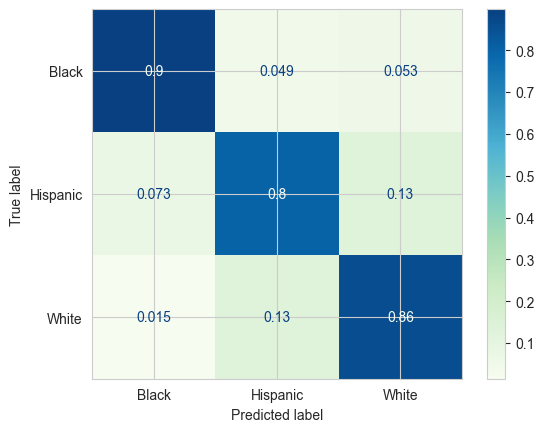

In [64]:
# normalize the matrix to show percentage of correctly classified samples
ConfusionMatrixDisplay.from_estimator(lr_model_grid,X_test, y_test,normalize='true', cmap='GnBu');

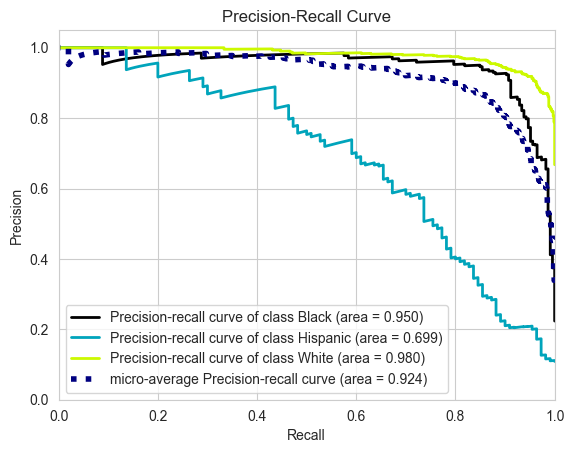

In [67]:
# getting classes probs from the tuned model

y_pred_proba = lr_model_grid.predict_proba(X_test)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

## 2. SVC

### Vanilla SVC model 

In [68]:
# SVM model
svm = SVC(random_state=2023)

svm_pipe = make_pipeline(column_trans, sc, svm)

svm_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'Component',
                                                   'Branch',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('minmaxscaler', MinMaxScaler()),
                ('svc', SVC(random_state=2023))])

In [69]:
eval_metric(svm_pipe, X_train, y_train, X_test, y_test)

Train_Set
[[ 822    4   79]
 [  18  143  277]
 [   9    8 2682]]
              precision    recall  f1-score   support

       Black       0.97      0.91      0.94       905
    Hispanic       0.92      0.33      0.48       438
       White       0.88      0.99      0.93      2699

    accuracy                           0.90      4042
   macro avg       0.92      0.74      0.78      4042
weighted avg       0.91      0.90      0.89      4042


Test_Set
[[188   1  37]
 [  7  33  70]
 [  5   4 666]]
              precision    recall  f1-score   support

       Black       0.94      0.83      0.88       226
    Hispanic       0.87      0.30      0.45       110
       White       0.86      0.99      0.92       675

    accuracy                           0.88      1011
   macro avg       0.89      0.71      0.75      1011
weighted avg       0.88      0.88      0.86      1011



###  SVC Model GridsearchCV

In [70]:
svm_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    ['Gender', 'Component', 'Branch',
                                     'SubjectsBirthLocation',
                                     'WritingPreference'])],
                     verbose_feature_names_out=False)),
  ('minmaxscaler', MinMaxScaler()),
  ('svc', SVC(random_state=2023))],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse_output=False),
                                  ['Gender', 'Component', 'Branch',
                                   'S

In [71]:
svm_param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'poly', 'rbf'],
    'svc__degree': [2, 3, 4],
    'svc__class_weight': ['balanced'] #not testing other weights to reduce compt time
}

In [72]:
svm_model_grid = GridSearchCV(svm_pipe,
                              svm_param_grid ,
                              scoring=recall_hespanic,
                              cv=10,
                              n_jobs=-1,
                              return_train_score=True)
svm_model_grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Gender',
                                                                          'Component',
                                                                          'Branch',
                                                                          'SubjectsBirthLocation',
                                                                          'WritingPreference'])],
                                                          verbose_feature_names_out=False)),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('svc', SVC(random_state=2023))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10],
                         'svc__class_weight': ['balanced'],
                         'svc__degree': [2, 3, 4],
                         'svc__kernel': ['linear', 'poly', 'rbf']},
             return_train_score=True,
             scoring=make_scorer(recall_score, average=None, labels=['Hispanic']))

In [73]:
svm_model_grid.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'Component',
                                                   'Branch',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('minmaxscaler', MinMaxScaler()),
                ('svc',
                 SVC(C=0.1, class_weight='balanced', kernel='poly',
                     random_state=2023))])

In [74]:
eval_metric(svm_model_grid, X_train, y_train, X_test, y_test)

Train_Set
[[ 836   39   30]
 [  14  384   40]
 [  47  478 2174]]
              precision    recall  f1-score   support

       Black       0.93      0.92      0.93       905
    Hispanic       0.43      0.88      0.57       438
       White       0.97      0.81      0.88      2699

    accuracy                           0.84      4042
   macro avg       0.78      0.87      0.79      4042
weighted avg       0.90      0.84      0.86      4042


Test_Set
[[197  14  15]
 [  7  89  14]
 [  7 114 554]]
              precision    recall  f1-score   support

       Black       0.93      0.87      0.90       226
    Hispanic       0.41      0.81      0.54       110
       White       0.95      0.82      0.88       675

    accuracy                           0.83      1011
   macro avg       0.76      0.83      0.78      1011
weighted avg       0.89      0.83      0.85      1011



In [75]:
pd.DataFrame(svm_model_grid.cv_results_).loc[
    svm_model_grid.best_index_, ["mean_test_score", "mean_train_score"]
]

mean_test_score      0.79667
mean_train_score    0.875953
Name: 4, dtype: object

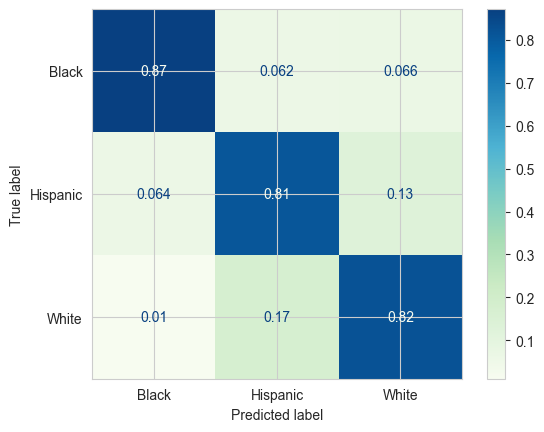

In [76]:
ConfusionMatrixDisplay.from_estimator(svm_model_grid,X_test, y_test,normalize='true', cmap='GnBu');

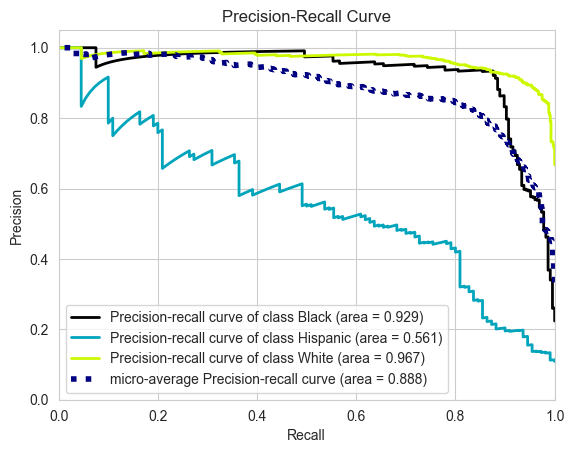

In [77]:
# getting classes probs from the tuned model
y_pred_proba = svm_model_grid.decision_function(X_test)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

although the results on test are high the class has weak precision scores

In [78]:
# testing with f1 score
svm_model_grid2 = GridSearchCV(svm_pipe,
                              svm_param_grid ,
                              scoring=f1_hespanic,
                              cv=10,
                              n_jobs=-1,
                              return_train_score=True)
svm_model_grid2.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Gender',
                                                                          'Component',
                                                                          'Branch',
                                                                          'SubjectsBirthLocation',
                                                                          'WritingPreference'])],
                                                          verbose_feature_names_out=False)),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('svc', SVC(random_state=2023))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10],
                         'svc__class_weight': ['balanced'],
                         'svc__degree': [2, 3, 4],
                         'svc__kernel': ['linear', 'poly', 'rbf']},
             return_train_score=True,
             scoring=make_scorer(f1_score, average=None, labels=['Hispanic']))

In [79]:
pd.DataFrame(svm_model_grid2.cv_results_).loc[
    svm_model_grid2.best_index_, ["mean_test_score", "mean_train_score"]
]

mean_test_score     0.571747
mean_train_score    0.835156
Name: 20, dtype: object

In [81]:
eval_metric(svm_model_grid2, X_train, y_train, X_test, y_test)

Train_Set
[[ 895    5    5]
 [   0  430    8]
 [  18  171 2510]]
              precision    recall  f1-score   support

       Black       0.98      0.99      0.98       905
    Hispanic       0.71      0.98      0.82       438
       White       0.99      0.93      0.96      2699

    accuracy                           0.95      4042
   macro avg       0.89      0.97      0.92      4042
weighted avg       0.96      0.95      0.95      4042


Test_Set
[[202   6  18]
 [ 10  78  22]
 [  8  71 596]]
              precision    recall  f1-score   support

       Black       0.92      0.89      0.91       226
    Hispanic       0.50      0.71      0.59       110
       White       0.94      0.88      0.91       675

    accuracy                           0.87      1011
   macro avg       0.79      0.83      0.80      1011
weighted avg       0.89      0.87      0.87      1011



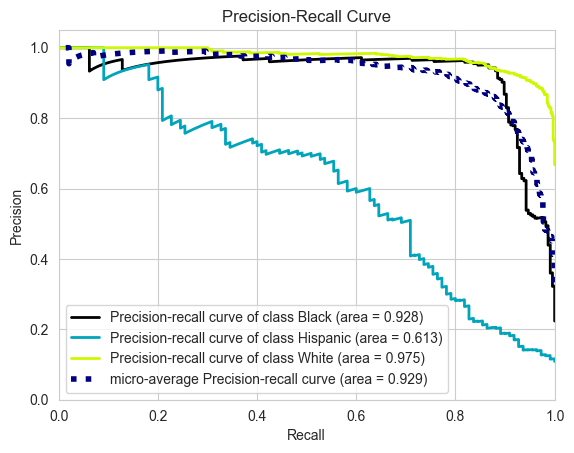

In [80]:
y_pred_proba = svm_model_grid2.decision_function(X_test)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

better than before but not better than tuned LR model

## 3. RF

### Vanilla RF Model

In [82]:
# tree-based models do not need one-hot encoding
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-1)


column_trans2 = make_column_transformer((ord_enc, cat_columns),
                                        remainder='passthrough',
                                        verbose_feature_names_out=False).set_output(transform="pandas")

In [83]:
# Vanilla RF
rf = RandomForestClassifier(random_state=2023)

rf_pipe = make_pipeline(column_trans2, rf) #no need for scaling 

rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Gender', 'Component',
                                                   'Branch',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=2023))])

In [84]:
eval_metric(rf_pipe, X_train, y_train, X_test, y_test)

Train_Set
[[ 905    0    0]
 [   0  438    0]
 [   0    0 2699]]
              precision    recall  f1-score   support

       Black       1.00      1.00      1.00       905
    Hispanic       1.00      1.00      1.00       438
       White       1.00      1.00      1.00      2699

    accuracy                           1.00      4042
   macro avg       1.00      1.00      1.00      4042
weighted avg       1.00      1.00      1.00      4042


Test_Set
[[153   1  72]
 [ 16   3  91]
 [  7   2 666]]
              precision    recall  f1-score   support

       Black       0.87      0.68      0.76       226
    Hispanic       0.50      0.03      0.05       110
       White       0.80      0.99      0.89       675

    accuracy                           0.81      1011
   macro avg       0.72      0.56      0.57      1011
weighted avg       0.79      0.81      0.77      1011



The model is overfitting the data and the recall for hespanic is zero

### RF Model GridsearchCV

In [85]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ordinalencoder',
                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                   unknown_value=-1),
                                    ['Gender', 'Component', 'Branch',
                                     'SubjectsBirthLocation',
                                     'WritingPreference'])],
                     verbose_feature_names_out=False)),
  ('randomforestclassifier', RandomForestClassifier(random_state=2023))],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('ordinalencoder',
                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                 unknown_value=-1),
                                  ['Gender', 'Component', 'Branch',
             

In [86]:
rf_param_grid = {
    'randomforestclassifier__class_weight':['balanced', {'White':1,'Hispanic':3.5,'Black':2}, 
              {'White':1,'Hispanic':4,'Black':2.5}, {'White':1,'Hispanic':4.5,'Black':2}],
    'randomforestclassifier__criterion':['gini','entropy','logg_loss'],
    'randomforestclassifier__max_depth':[2,3,4,5]
}

In [87]:
rf_model_grid = GridSearchCV(rf_pipe,
                              rf_param_grid ,
                              scoring=recall_hespanic,
                              cv=10,
                              n_jobs=-1,
                              return_train_score=True)
rf_model_grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Gender',
                                                                          'Component',
                                                                          'Branch',
                                                                          'SubjectsBirthLocation',
                                                                          'WritingPreference'])],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestclassifier',
                                        Rand...
             param_grid={'randomforestclassifier__class_weight': ['balanced',
                                                                  {'Black': 2,
                                                                   'Hispanic': 3.5,
                                                                   'White': 1},
                                                                  {'Black': 2.5,
                                                                   'Hispanic': 4,
                                                                   'White': 1},
                                                                  {'Black': 2,
                                                                   'Hispanic': 4.5,
                                                                   'White': 1}],
                         'randomforestclassifier__criterion': ['gini',
                                                               'entropy',
                                                               'logg_loss'],
                         'randomforestclassifier__max_depth': [2, 3, 4, 5]},
             return_train_score=True,
             scoring=make_scorer(recall_score, average=None, labels=['Hispanic']))

In [88]:
rf_model_grid.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Gender', 'Component',
                                                   'Branch',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=4,
                                        random_state=2023))])

In [89]:
eval_metric(rf_model_grid, X_train, y_train, X_test, y_test)

Train_Set
[[ 760   80   65]
 [  38  287  113]
 [ 253  719 1727]]
              precision    recall  f1-score   support

       Black       0.72      0.84      0.78       905
    Hispanic       0.26      0.66      0.38       438
       White       0.91      0.64      0.75      2699

    accuracy                           0.69      4042
   macro avg       0.63      0.71      0.63      4042
weighted avg       0.80      0.69      0.72      4042


Test_Set
[[173  28  25]
 [ 23  60  27]
 [ 58 189 428]]
              precision    recall  f1-score   support

       Black       0.68      0.77      0.72       226
    Hispanic       0.22      0.55      0.31       110
       White       0.89      0.63      0.74       675

    accuracy                           0.65      1011
   macro avg       0.60      0.65      0.59      1011
weighted avg       0.77      0.65      0.69      1011



In [90]:
pd.DataFrame(rf_model_grid.cv_results_).loc[
    rf_model_grid.best_index_, ["mean_test_score", "mean_train_score"]
]

mean_test_score     0.566068
mean_train_score    0.666414
Name: 6, dtype: object

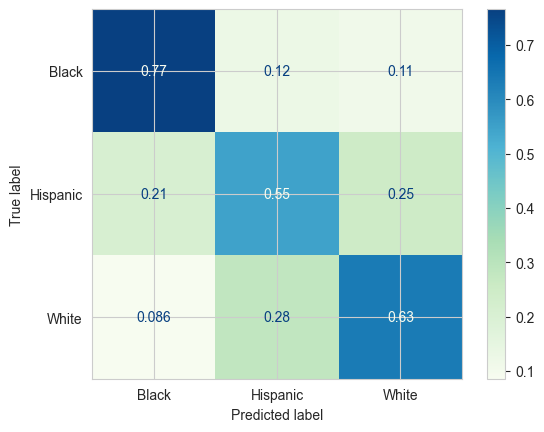

In [91]:
ConfusionMatrixDisplay.from_estimator(rf_model_grid,X_test, y_test,normalize='true', cmap='GnBu');

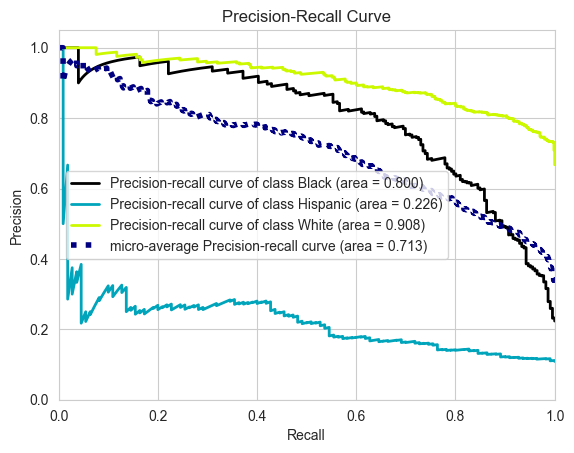

In [92]:
# getting classes probs from the tuned model
y_pred_proba = rf_model_grid.predict_proba(X_test)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

very bad results for hespanic :( 

In [93]:
# testing with f1
rf_model_grid2 = GridSearchCV(rf_pipe,
                              rf_param_grid ,
                              scoring=f1_hespanic,
                              cv=10,
                              n_jobs=-1,
                              return_train_score=True)
rf_model_grid2.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Gender',
                                                                          'Component',
                                                                          'Branch',
                                                                          'SubjectsBirthLocation',
                                                                          'WritingPreference'])],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestclassifier',
                                        Rand...
             param_grid={'randomforestclassifier__class_weight': ['balanced',
                                                                  {'Black': 2,
                                                                   'Hispanic': 3.5,
                                                                   'White': 1},
                                                                  {'Black': 2.5,
                                                                   'Hispanic': 4,
                                                                   'White': 1},
                                                                  {'Black': 2,
                                                                   'Hispanic': 4.5,
                                                                   'White': 1}],
                         'randomforestclassifier__criterion': ['gini',
                                                               'entropy',
                                                               'logg_loss'],
                         'randomforestclassifier__max_depth': [2, 3, 4, 5]},
             return_train_score=True,
             scoring=make_scorer(f1_score, average=None, labels=['Hispanic']))

In [95]:
pd.DataFrame(rf_model_grid2.cv_results_).loc[
    rf_model_grid2.best_index_, ["mean_test_score", "mean_train_score"]
]

mean_test_score     0.333142
mean_train_score    0.435796
Name: 3, dtype: object

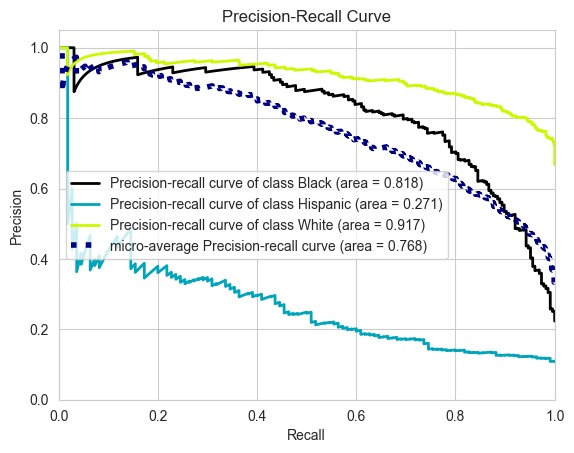

In [96]:
y_pred_proba = rf_model_grid2.predict_proba(X_test)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

Random forest showed the worst results so far

## 4. XGBoost

### Vanilla XGBoost Model

In [97]:
# ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['Black' 'Hispanic' 'White']
y_train_encoded = y_train.map({'Black':0, 'Hispanic':1, 'White':2})
y_test_encoded = y_test.map({'Black':0, 'Hispanic':1, 'White':2})

In [98]:
# fixing the labels for scoring
xgb_f1_hespanic = make_scorer(f1_score, average=None, labels=[1])

xgb_precision_hespanic = make_scorer(precision_score, average=None, labels=[1])

xgb_recall_hespanic = make_scorer(recall_score, average=None, labels=[1])


xgb_scoring = {'f1_hespanic': xgb_f1_hespanic,
           'precision_hespanic': xgb_precision_hespanic, 
           'recall_hespanic': xgb_recall_hespanic}

In [99]:
# XGBoost 
xgb =  XGBClassifier(random_state=2023)

# no need for scaler 
# using ordinal transformer
xgb_pipe = make_pipeline(column_trans2, xgb)

xgb_pipe.fit(X_train, y_train_encoded)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Gender', 'Component',
                                                   'Branch',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [100]:
eval_metric(xgb_pipe, X_train, y_train_encoded, X_test, y_test_encoded)

Train_Set
[[ 905    0    0]
 [   0  438    0]
 [   0    0 2699]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       905
           1       1.00      1.00      1.00       438
           2       1.00      1.00      1.00      2699

    accuracy                           1.00      4042
   macro avg       1.00      1.00      1.00      4042
weighted avg       1.00      1.00      1.00      4042


Test_Set
[[189   1  36]
 [ 11  42  57]
 [  5  11 659]]
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       226
           1       0.78      0.38      0.51       110
           2       0.88      0.98      0.92       675

    accuracy                           0.88      1011
   macro avg       0.86      0.73      0.77      1011
weighted avg       0.88      0.88      0.87      1011



### XGBoost Model GridsearchCV

In [101]:
xgb_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ordinalencoder',
                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                   unknown_value=-1),
                                    ['Gender', 'Component', 'Branch',
                                     'SubjectsBirthLocation',
                                     'WritingPreference'])],
                     verbose_feature_names_out=False)),
  ('xgbclassifier',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=None

In [102]:
xgb_param_grid = {'xgbclassifier__n_estimators': [50,100,150,200],
                  'xgbclassifier__max_depth': [2, 3, 4, 5],
                  }
                  # 'xgbclassifier__scale_pos_weight' is only for binary classification

In [103]:
# computing the balanced weights for each class 
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [104]:
class_weights

array([1.48876611, 3.0761035 , 0.49919723])

In [105]:
# into dict format
class_weights = {0: 1.4820167, 1: 2.8330264, 2: 0.50703142}

In [106]:
#  list of sample weights based on the labels
sample_weights = [class_weights[label] for label in y_train_encoded]

In [107]:
# passing the weights in pipeline fit caused an issue for me
kwargs = {xgb_pipe.steps[-1][0] + '__sample_weight': sample_weights}
# bug fix found for scikit-learn issues in github [3]

In [108]:
xgb_pipe.fit(X_train, y_train_encoded, **kwargs)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Gender', 'Component',
                                                   'Branch',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

yay it worked :)

In [134]:
xgb_model_grid = GridSearchCV(xgb_pipe,
                             xgb_param_grid,
                             scoring=xgb_recall_hespanic, #update scorer
                             cv=10,
                             n_jobs=-1,
                             return_train_score=True)
xgb_model_grid.fit(X_train, y_train_encoded)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Gender',
                                                                          'Component',
                                                                          'Branch',
                                                                          'SubjectsBirthLocation',
                                                                          'WritingPreference'])],
                                                          verbose_feature_names_out=False)),
                                       ('xgbclassifier',
                                        XGBClassifier...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      objective='multi:softprob',
                                                      predictor=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__max_depth': [2, 3, 4, 5],
                         'xgbclassifier__n_estimators': [50, 100, 150, 200]},
             return_train_score=True,
             scoring=make_scorer(recall_score, average=None, labels=[1]))

In [135]:
xgb_model_grid.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Gender', 'Component',
                                                   'Branch',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [136]:
eval_metric(xgb_model_grid, X_train, y_train_encoded, X_test, y_test_encoded)

Train_Set
[[ 886    0   19]
 [   5  334   99]
 [   4    5 2690]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       905
           1       0.99      0.76      0.86       438
           2       0.96      1.00      0.98      2699

    accuracy                           0.97      4042
   macro avg       0.98      0.91      0.94      4042
weighted avg       0.97      0.97      0.97      4042


Test_Set
[[187   6  33]
 [  8  49  53]
 [  9  14 652]]
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       226
           1       0.71      0.45      0.55       110
           2       0.88      0.97      0.92       675

    accuracy                           0.88      1011
   macro avg       0.84      0.75      0.78      1011
weighted avg       0.87      0.88      0.87      1011



The model is overfitting the data

we must fix the scorrer to the new labels

In [137]:
# after fixing scorer
pd.DataFrame(xgb_model_grid.cv_results_).loc[
    xgb_model_grid.best_index_, ["mean_test_score", "mean_train_score"]
]

mean_test_score     0.378964
mean_train_score    0.786405
Name: 3, dtype: object

overfitting confirmed

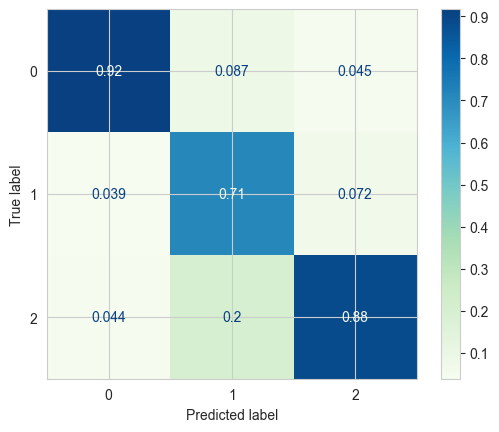

In [138]:
ConfusionMatrixDisplay.from_estimator(xgb_model_grid,X_test, y_test_encoded,normalize='pred', cmap='GnBu');

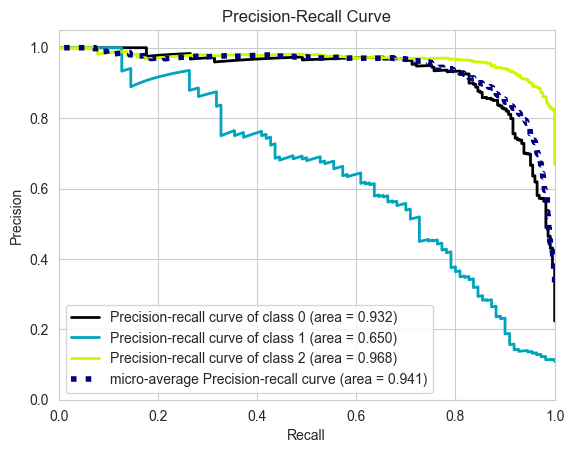

In [139]:
# getting classes probs from the tuned model
y_pred_proba = xgb_model_grid.predict_proba(X_test)

plot_precision_recall(y_test_encoded, y_pred_proba)
plt.show();

trying to improve with f1 score

In [140]:
xgb_model_grid2 = GridSearchCV(xgb_pipe,
                             xgb_param_grid,
                             scoring=xgb_f1_hespanic, 
                             cv=10,
                             n_jobs=-1,
                             return_train_score=True)
xgb_model_grid2.fit(X_train, y_train_encoded)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Gender',
                                                                          'Component',
                                                                          'Branch',
                                                                          'SubjectsBirthLocation',
                                                                          'WritingPreference'])],
                                                          verbose_feature_names_out=False)),
                                       ('xgbclassifier',
                                        XGBClassifier...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      objective='multi:softprob',
                                                      predictor=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__max_depth': [2, 3, 4, 5],
                         'xgbclassifier__n_estimators': [50, 100, 150, 200]},
             return_train_score=True,
             scoring=make_scorer(f1_score, average=None, labels=[1]))

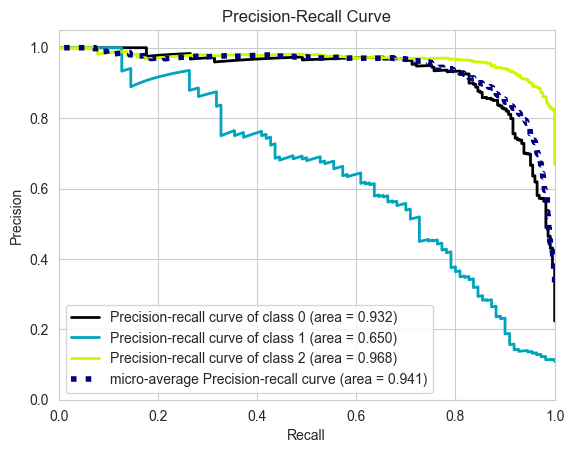

In [141]:
y_pred_proba = xgb_model_grid2.predict_proba(X_test)

plot_precision_recall(y_test_encoded, y_pred_proba)
plt.show();

similar results

## Performance comparison 

### Vanilla models performance

In [118]:
# passing the trained vanilla models piplines


# logistic regression
lr_scores = cross_validate(lr_pipe,
                        X_train,
                        y_train,
                        scoring=scoring,
                        cv = 10,
                        n_jobs=-1,
                        return_train_score=True)

#support vector machines
svm_scores = cross_validate(svm_pipe,
                        X_train,
                        y_train,
                        scoring=scoring,
                        cv = 10,
                        n_jobs=-1,
                        return_train_score=True)
# random forest                   
rf_scores = cross_validate(rf_pipe,
                        X_train,
                        y_train,
                        scoring=scoring,
                        cv = 10,
                        n_jobs=-1,
                        return_train_score=True)                 
                     
# XGBoost                     
xgb_scores = cross_validate(xgb_pipe,
                        X_train,
                        y_train_encoded,
                        scoring=xgb_scoring,
                        cv = 10,
                        n_jobs=-1,
                        return_train_score=True)  

                     

In [119]:
vanilla_models_score = {
    'Logistic Regression': lr_scores,
    'Support Vector Machines': svm_scores,
    'Random Forest': rf_scores,
    'XGBoost': xgb_scores
}    

In [120]:
vanilla_models_score['Logistic Regression']['test_f1_hespanic'].mean()

0.6029052526273375

storing each scores in a dict

In [121]:
test_f1_hespanic_scores = {}

for model_name, model_scores in vanilla_models_score.items():
    test_f1_hespanic_score = model_scores['test_f1_hespanic'].mean()
    test_f1_hespanic_scores[model_name] = test_f1_hespanic_score

In [122]:
test_recall_hespanic_scores = {}

for model_name, model_scores in vanilla_models_score.items():
    test_recall_hespanic_score = model_scores['test_recall_hespanic'].mean()
    test_recall_hespanic_scores[model_name] = test_recall_hespanic_score

In [123]:
test_precision_hespanic_scores = {}

for model_name, model_scores in vanilla_models_score.items():
    test_precision_hespanic_score = model_scores['test_precision_hespanic'].mean()
    test_precision_hespanic_scores[model_name] = test_precision_hespanic_score

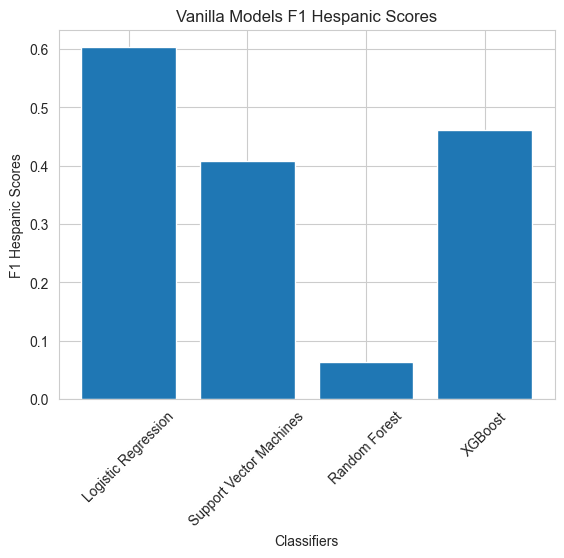

In [124]:
plt.bar(range(len(test_f1_hespanic_scores)), list(test_f1_hespanic_scores.values()), align='center')
plt.xticks(range(len(test_f1_hespanic_scores)), list(test_f1_hespanic_scores.keys()), rotation=45)
plt.xlabel('Classifiers')
plt.ylabel('F1 Hespanic Scores')
plt.title('Vanilla Models F1 Hespanic Scores')
plt.show()

The random forest vanilla model showed the worst f1 results compared to other

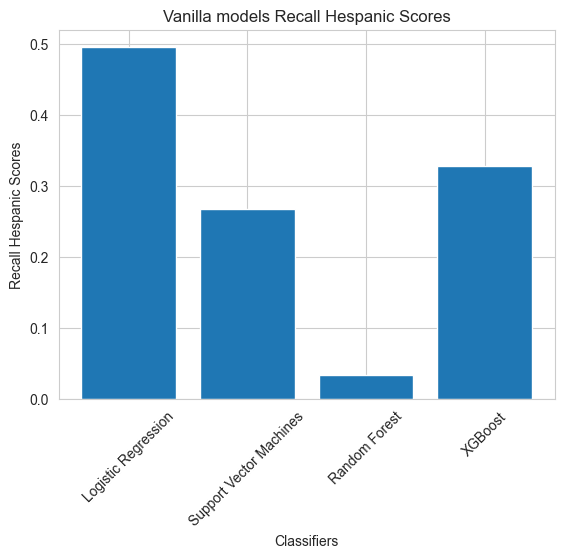

In [125]:
plt.bar(range(len(test_recall_hespanic_scores)), list(test_recall_hespanic_scores.values()), align='center')
plt.xticks(range(len(test_recall_hespanic_scores)), list(test_recall_hespanic_scores.keys()), rotation=45)
plt.xlabel('Classifiers')
plt.ylabel('Recall Hespanic Scores')
plt.title('Vanilla models Recall Hespanic Scores')
plt.show()

The Logistic regression vanilla model showed a good recall score compared to others

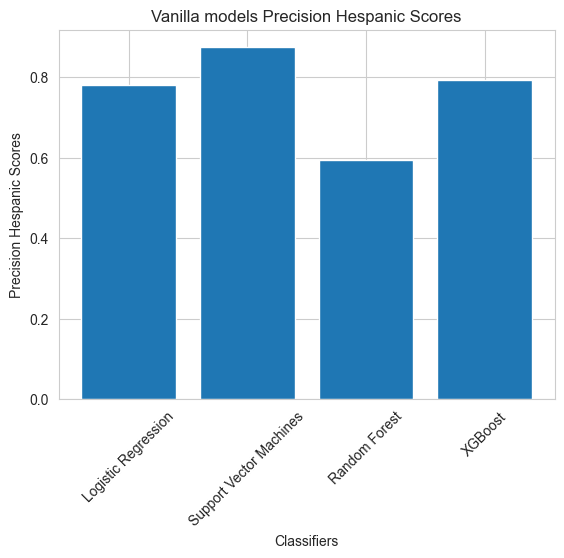

In [126]:
plt.bar(range(len(test_precision_hespanic_scores)), list(test_precision_hespanic_scores.values()), align='center')
plt.xticks(range(len(test_precision_hespanic_scores)), list(test_precision_hespanic_scores.keys()), rotation=45)
plt.xlabel('Classifiers')
plt.ylabel('Precision Hespanic Scores')
plt.title('Vanilla models Precision Hespanic Scores')
plt.show()

SVM has the highest precision scores

### Tuned Models comparison 

In [142]:
# passing the tuned models best scores
lr_result = pd.DataFrame(lr_model_grid.cv_results_).loc[
    lr_model_grid.best_index_, ["mean_test_score"]].values.item()

svm_result = pd.DataFrame(svm_model_grid.cv_results_).loc[
    svm_model_grid.best_index_, ["mean_test_score"]].values.item()

rf_result = pd.DataFrame(lr_model_grid.cv_results_).loc[
    lr_model_grid.best_index_, ["mean_test_score"]].values.item()

xgb_results = pd.DataFrame(xgb_model_grid.cv_results_).loc[
    xgb_model_grid.best_index_, ["mean_test_score"]].values.item()

In [144]:
tuned_models_scores = {
    'Logistic Regression': lr_result,
    'Support Vector Machines': svm_result,
    'Random Forest': rf_result,
    'XGBoost': xgb_results
}

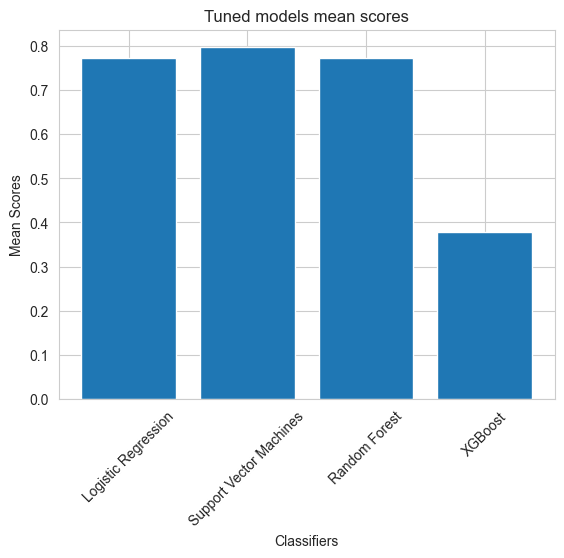

In [145]:
plt.bar(range(len(tuned_models_scores)), list(tuned_models_scores.values()), align='center')
plt.xticks(range(len(tuned_models_scores)), list(tuned_models_scores.keys()), rotation=45)
plt.xlabel('Classifiers')
plt.ylabel('Mean Scores')
plt.title('Tuned models mean scores')
plt.show()

Although SVM scored the highest score, it performed very poorly on the hispanic class

In [146]:
# since XGBoost and random forest are overfitting we will not use them for the final comparison
lr_pipe_scores = cross_validate(lr_model_grid, X_test, y_test, scoring=scoring, n_jobs=-1,)
svm_pipe_scores = cross_validate(svm_model_grid, X_test, y_test, scoring=scoring, n_jobs=-1,)

In [147]:
# caclculating the mean scores from cross val
results = {
    'Pipeline': ['Logistic Regression', 'SVM'],
    'F1_Hispanic': [lr_pipe_scores['test_f1_hespanic'].mean(), svm_pipe_scores['test_f1_hespanic'].mean()],
    'Precision_Hispanic': [lr_pipe_scores['test_precision_hespanic'].mean(), svm_pipe_scores['test_precision_hespanic'].mean()],
    'Recall_Hispanic': [lr_pipe_scores['test_recall_hespanic'].mean(), svm_pipe_scores['test_recall_hespanic'].mean()]
}
compare = pd.DataFrame(results)  
compare

Pipeline  F1_Hispanic  Precision_Hispanic  Recall_Hispanic
0  Logistic Regression     0.560060            0.450515         0.745455
1                  SVM     0.512673            0.385620         0.772727

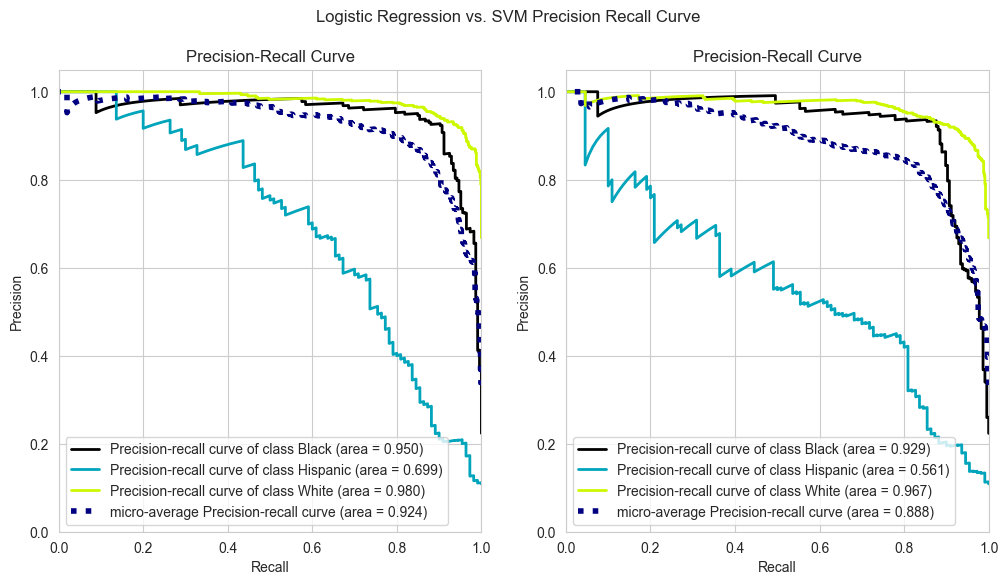

In [148]:
# displaying recall precision curves

y_pred_proba_lr = lr_model_grid.predict_proba(X_test)
y_pred_proba_svm = svm_model_grid.decision_function(X_test)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_precision_recall(y_test, y_pred_proba_lr, ax=axs[0])
plot_precision_recall(y_test, y_pred_proba_svm, ax=axs[1])


plt.suptitle('Logistic Regression vs. SVM Precision Recall Curve')
plt.show()

As we can see the logistic regression model has better scores for its classes compared to SVM. Therefore, legistic regression will be our final model.

---
---

---
---

# SMOTE

Trying to handle imbalanced classes using synthesize data to balance the minority class. <br>
Following the tutrioal provided in [2] 

##  Smote implement

In [150]:
oversampling = SMOTE(sampling_strategy = 'minority', random_state = 2023)
undersampling = RandomUnderSampler(sampling_strategy = 'not minority', random_state = 2023)

## Logistic Regression Over/ Under Sampling

In [151]:
# make pipeline and pipeline cannot handle SMOTE so we are using the pipline from imblearn
from imblearn.pipeline import Pipeline as impip

In [152]:
# trying the oversampler
steps = [('transformer', column_trans), ('over', oversampling), ('scaler', sc),
         ('Tuned logistic Regression', LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                                          random_state=2023, solver='sag'))]

lr_pipe_oversampling = impip(steps=steps)

lr_pipe_oversampling.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'Component',
                                                   'Branch',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('over',
                 SMOTE(random_state=2023, sampling_strategy='minority')),
                ('scaler', MinMaxScaler()),
                ('Tuned logistic Regression',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                    random_state=2023, solver='sag'))])

In [153]:
eval_metric(lr_pipe_oversampling, X_train, y_train, X_test, y_test)

Train_Set
[[ 857   26   22]
 [  23  343   72]
 [  57  341 2301]]
              precision    recall  f1-score   support

       Black       0.91      0.95      0.93       905
    Hispanic       0.48      0.78      0.60       438
       White       0.96      0.85      0.90      2699

    accuracy                           0.87      4042
   macro avg       0.79      0.86      0.81      4042
weighted avg       0.90      0.87      0.88      4042


Test_Set
[[205   9  12]
 [  9  84  17]
 [ 10  84 581]]
              precision    recall  f1-score   support

       Black       0.92      0.91      0.91       226
    Hispanic       0.47      0.76      0.59       110
       White       0.95      0.86      0.90       675

    accuracy                           0.86      1011
   macro avg       0.78      0.84      0.80      1011
weighted avg       0.89      0.86      0.87      1011



In [154]:
scores = cross_validate(lr_pipe_oversampling,
                        X_train,
                        y_train,
                        scoring=recall_hespanic,
                        cv = 10,
                        n_jobs=-1,
                        return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_score     0.737474
train_score    0.795027
dtype: float64

In [155]:
# trying the undersampler
steps = [('transformer', column_trans), ('under', undersampling), ('scaler', sc),
         ('Tuned logistic Regression', LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                                          random_state=2023, solver='sag'))]

lr_pipe_under= impip(steps=steps)

lr_pipe_under.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'Component',
                                                   'Branch',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('under',
                 RandomUnderSampler(random_state=2023,
                                    sampling_strategy='not minority')),
                ('scaler', MinMaxScaler()),
                ('Tuned logistic Regression',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                    random_state=2023, solver='sag'))])

In [156]:
eval_metric(lr_pipe_under, X_train, y_train, X_test, y_test)

Train_Set
[[ 837   43   25]
 [  18  364   56]
 [  70  478 2151]]
              precision    recall  f1-score   support

       Black       0.90      0.92      0.91       905
    Hispanic       0.41      0.83      0.55       438
       White       0.96      0.80      0.87      2699

    accuracy                           0.83      4042
   macro avg       0.76      0.85      0.78      4042
weighted avg       0.89      0.83      0.85      4042


Test_Set
[[203  13  10]
 [  8  88  14]
 [ 12 113 550]]
              precision    recall  f1-score   support

       Black       0.91      0.90      0.90       226
    Hispanic       0.41      0.80      0.54       110
       White       0.96      0.81      0.88       675

    accuracy                           0.83      1011
   macro avg       0.76      0.84      0.78      1011
weighted avg       0.89      0.83      0.85      1011



In [157]:
scores = cross_validate(lr_pipe_under,
                        X_train,
                        y_train,
                        scoring=recall_hespanic,
                        cv = 10,
                        n_jobs=-1,
                        return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_score     0.769662
train_score    0.831815
dtype: float64

The results for under/over sampling is not better than the tuned logistic regression model

## Other Evaluation Metrics for Multiclass Classification

Testing other metrics for multiclass 

In [159]:
# tuned lr model
matthews_corrcoef(y_test, lr_model_grid.predict(X_test)).__round__(4)

0.7465

In [161]:
# undersampling model
matthews_corrcoef(y_test, lr_pipe_under.predict(X_test)).__round__(4)

0.7093

In [162]:
# tuned lr model
cohen_kappa_score(y_test, lr_model_grid.predict(X_test)).__round__(4)

0.7377

In [163]:
# oversampling model
cohen_kappa_score(y_test, lr_pipe_oversampling.predict(X_test)).__round__(4)

0.7133

# SHAP Analysis

Explaining the models prediction based on the Classis Shaply values from Game theory using SHAP library [5]

In [164]:
lr = LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                   random_state=2023, solver='sag')

shap_pipe_lr = make_pipeline(column_trans, sc, lr)

shap_pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'Component',
                                                   'Branch',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                    random_state=2023, solver='sag'))])

In [165]:
shap_pipe_lr.named_steps.logisticregression

LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                   random_state=2023, solver='sag')

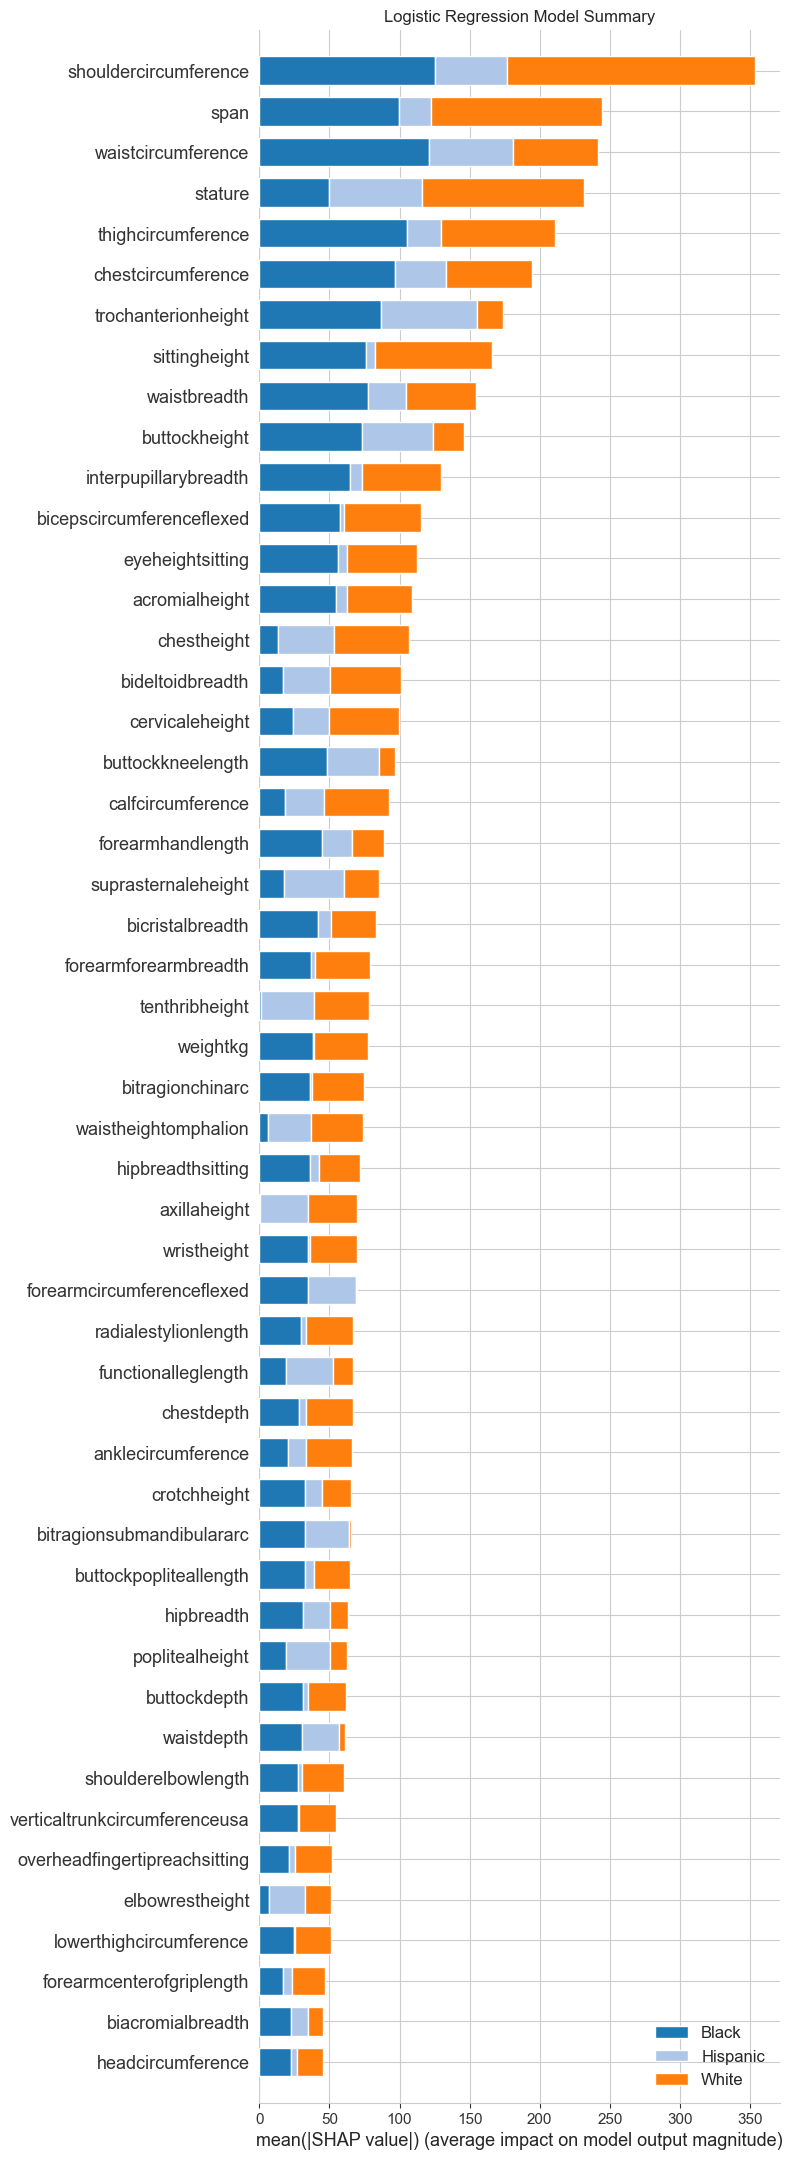

In [166]:
# transforimng X to get the features names
transformed_x = column_trans.fit_transform(X_train)
transformed_x_test = column_trans.fit_transform(X_test)

explainer = shap.Explainer(
    shap_pipe_lr.named_steps.logisticregression, transformed_x) # passing shap pipe
shap_values = explainer.shap_values(transformed_x_test)

shap.summary_plot(shap_values, transformed_x_test, show=False,
                  class_names={0: 'Black', 1: 'Hispanic', 2: 'White'},
                  class_inds='original',
                  max_display=50,  # display 50 features
                  color=plt.get_cmap('tab20'))
plt.title('Logistic Regression Model Summary')
plt.show()

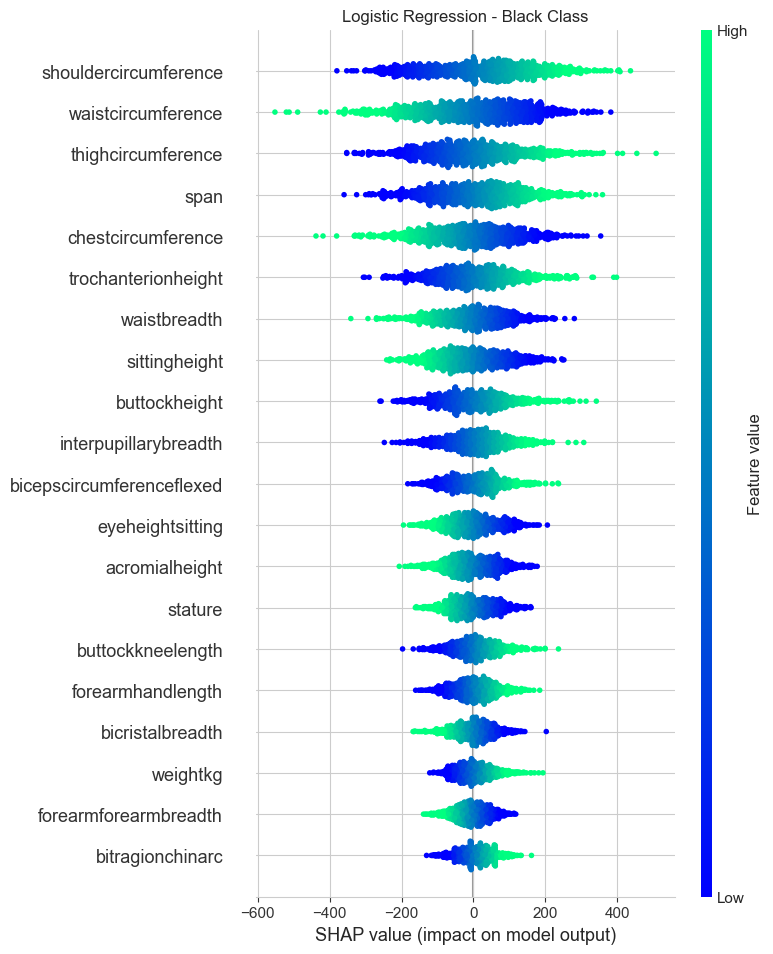

In [167]:
shap.summary_plot(shap_values[0], transformed_x_test, show=False, cmap=plt.get_cmap('winter'))
plt.title('Logistic Regression - Black Class')
plt.show()

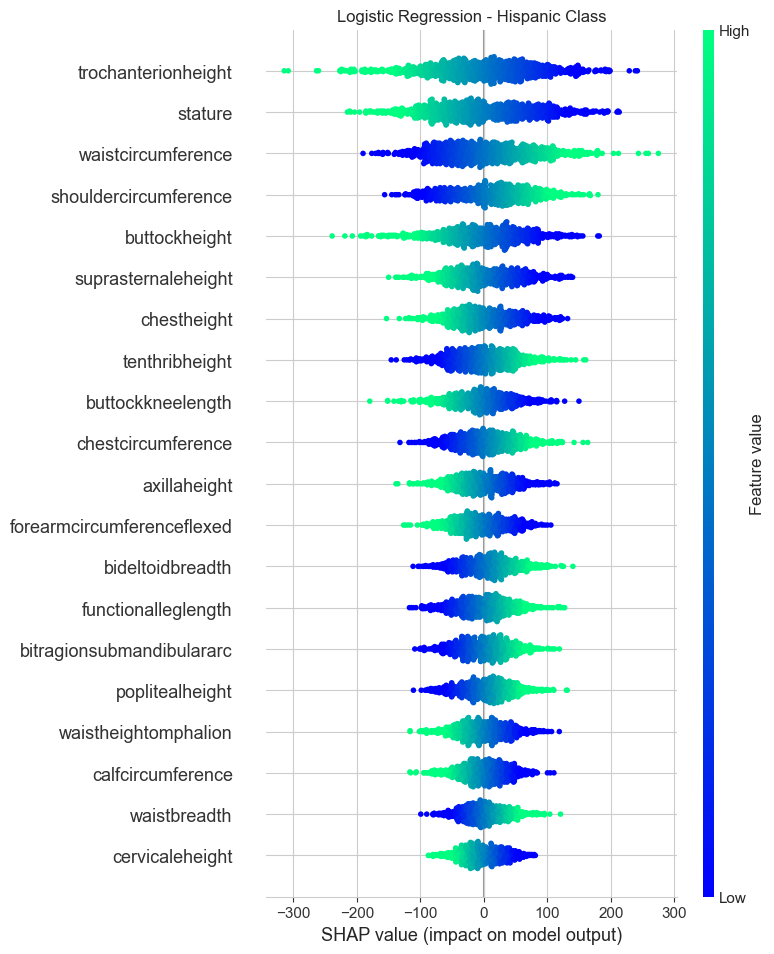

In [168]:
shap.summary_plot(shap_values[1], transformed_x_test, show=False, cmap=plt.get_cmap('winter'))
plt.title('Logistic Regression - Hispanic Class')
plt.show()

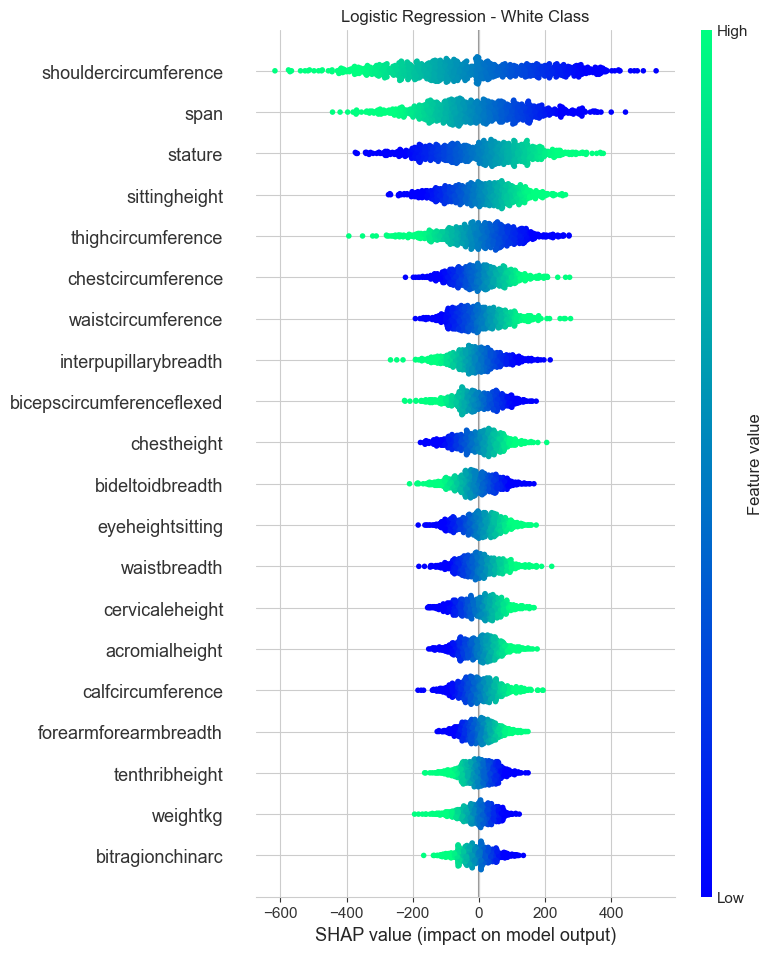

In [169]:
shap.summary_plot(shap_values[2], transformed_x_test, show=False, cmap=plt.get_cmap('winter'))
plt.title('Logistic Regression - White Class')
plt.show()

In [170]:
hispanic_features =[
'trochanterionheight',
'stature',
'waistcircumference',
'shouldercircumference',
'buttockheight',
'suprasternaleheight',
'chestheight',
'tenthribheight',
'buttockkneelength',
'chestcircumference',
'axillaheight',
'forearmcircumferenceflexed',
'bideltoidbreadth',
'functionalleglength',
'bitragionsubmandibulararc',
'poplitealheight',
'waistheightomphalion',
'calfcircumference',
'waistbreadth',
'cervicaleheight',  
]

Testing the features with new model:

In [171]:
new_df = X[hispanic_features]
new_df.head()

trochanterionheight  stature  waistcircumference  shouldercircumference  \
0                  918     1702                 870                   1119   
1                  918     1735                 964                   1276   
2                  847     1655                 857                   1155   
3                 1090     1914                 868                   1231   
4                  898     1720                 950                   1172   

   buttockheight  suprasternaleheight  chestheight  tenthribheight  \
0            870                 1387         1244            1076   
1            901                 1438         1288            1105   
2            821                 1346         1205            1021   
3           1080                 1596         1452            1292   
4            871                 1411         1253            1080   

   buttockkneelength  chestcircumference  axillaheight  \
0                584                1021          1293   
1                623                1120          1327   
2                560                1114          1239   
3                706                1048          1478   
4                599                1066          1293   

   forearmcircumferenceflexed  bideltoidbreadth  functionalleglength  \
0                         289               479                 1096   
1                         357               544                 1115   
2                         318               518                 1034   
3                         324               524                 1279   
4                         298               502                 1126   

   bitragionsubmandibulararc  poplitealheight  waistheightomphalion  \
0                        320              417                  1054   
1                        330              431                  1041   
2                        309              393                   968   
3                        310              523                  1245   
4                        319              419                  1020   

   calfcircumference  waistbreadth  cervicaleheight  
0                357           316             1471  
1                412           329             1501  
2                395           315             1423  
3                425           303             1684  
4                386           337             1489

In [172]:
cat = new_df.select_dtypes('object').columns
cat

Index([], dtype='object')

all are numerical values

In [173]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(new_df, y, test_size=0.2, stratify=y,random_state=2023)

In [174]:
lr = LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                   random_state=2023, solver='sag')

shap_pipe_lr = make_pipeline(sc, lr)

shap_pipe_lr.fit(X_train2, y_train2)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                    random_state=2023, solver='sag'))])

In [175]:
eval_metric(shap_pipe_lr, X_train2, y_train2, X_test2, y_test2)

Train_Set
[[ 753   87   65]
 [  49  270  119]
 [ 287  755 1657]]
              precision    recall  f1-score   support

       Black       0.69      0.83      0.76       905
    Hispanic       0.24      0.62      0.35       438
       White       0.90      0.61      0.73      2699

    accuracy                           0.66      4042
   macro avg       0.61      0.69      0.61      4042
weighted avg       0.78      0.66      0.69      4042


Test_Set
[[169  30  27]
 [ 22  63  25]
 [ 53 197 425]]
              precision    recall  f1-score   support

       Black       0.69      0.75      0.72       226
    Hispanic       0.22      0.57      0.32       110
       White       0.89      0.63      0.74       675

    accuracy                           0.65      1011
   macro avg       0.60      0.65      0.59      1011
weighted avg       0.77      0.65      0.69      1011



we still have low recall scores for Hispanic class

In [176]:
scores = cross_validate(shap_pipe_lr,
                        X_train2,
                        y_train2,
                        scoring=scoring,
                        cv = 10,
                        n_jobs=-1,
                        return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_f1_hespanic            0.346862
train_f1_hespanic           0.347535
test_precision_hespanic     0.241974
train_precision_hespanic    0.242223
test_recall_hespanic        0.613901
train_recall_hespanic       0.614916
dtype: float64

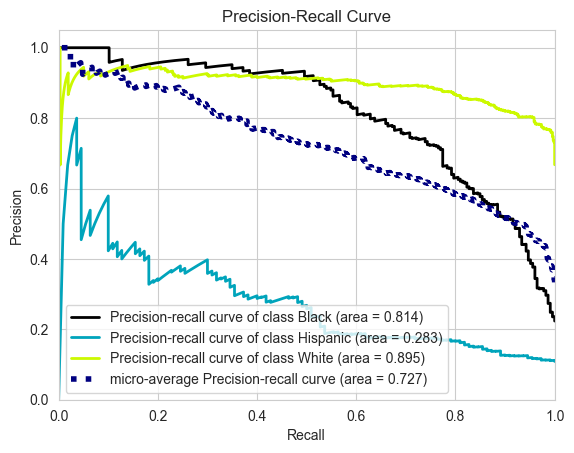

In [177]:
y_pred_proba = shap_pipe_lr.predict_proba(X_test2)

plot_precision_recall(y_test2, y_pred_proba)
plt.show();

feature selection through SHAP did not give us good results. <br>
However, it still helps us which features has more influence on prediction.

# For later Deployment 

In [178]:
best_model = LogisticRegression(C=1, 
                                class_weight='balanced', 
                                max_iter=1000,
                                 solver='sag',
                                random_state=2023)

final_pipe = make_pipeline(column_trans, sc, best_model)

final_pipe.fit(X, y) # fit the whole dataset

file = 'lr_trained_model.sav'
pickle.dump(final_pipe, open(file, 'wb'))

# References

[1] https://data.world/datamil/ansur-ii-data-dictionary/workspace/file?filename=ANSUR+II+Databases+Overview.pdf <br>
[2] https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/ <br>
[3] fitting sample_weight in pipeline issue fix https://github.com/scikit-learn/scikit-learn/issues/18159 <br>
[4] Evaluation metrics https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd <br>
[5] SHAP analysis https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___